# Investigatory Analysis: PPA Contract Structure and Bankability

Inspired by Gousis et al. (2025) "Enhancing the viability and bankability of hybrid RES-BESS systems with corporate power purchase agreements and electricity market participation", we investigate:

1. **Trade-off between bankability and market exposure**: How does the proportion of contracted vs. merchant energy affect project economics?
2. **Impact of certainty level on contract viability**: Relationship between risk tolerance (A_L) and secure delivery profiles
3. **Revenue stability analysis**: Comparing contracted vs. market revenues under different risk profiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from utils import (Expando, _calculate_S_star_BL_G,_calculate_S_star_BL_L, calculate_cvar_left, _left_tail_weighted_sum, _left_tail_mask )
import gurobipy as gp
from gurobipy import GRB
import copy
%matplotlib inline


In [2]:
 # Load Scenario Data
num_scenarios = 500
time_horizon = 20 #  5,10,20
discount_rate_G = 0.02 # %
discount_rate_L = 0.05 # %
alpha = 0.95  # Weighting factor for strike price calculation
contract_type = 'Baseload'  # Baseload ,PAP

#Discount Array 
discount_factors_G = 1 / (1 + discount_rate_G) ** np.arange(time_horizon)
discount_factors_G = discount_factors_G[:, None]

discount_factors_L = 1 / (1 + discount_rate_L) ** np.arange(time_horizon)
discount_factors_L = discount_factors_L[:, None]


scenario_pattern_reduced = f"{{type}}_scenarios_reduced_{time_horizon}y_{num_scenarios}s.csv"

# Load price scenarios
prices_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='price')}", index_col=0) # Mio EUR/GWh
prices_df.index = pd.to_datetime(prices_df.index)   
prices = prices_df.values
prices_mwh = prices_df * 1000  # Convert from EUR/GWh to EUR/MWh

#prices_mwh = prices_mwh + 0.01*prices_mwh.mean().mean()

# Load production scenarios
prod_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='production')}", index_col=0) # GWh
prod_df.index = pd.to_datetime(prod_df.index)
prod = prod_df.values
# Load capture rate scenarios
CR_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='capture_rate')}", index_col=0)
CR_df.index = pd.to_datetime(CR_df.index)    # Load load scenarios
CR = CR_df.values
load_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='load')}", index_col=0) # GWh
load_df.index = pd.to_datetime(load_df.index)
load = load_df.values

LR_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='load_capture_rate')}", index_col=0) # %
LR_df.index = pd.to_datetime(LR_df.index)
LR = LR_df.values

probability_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='probabilities')}", index_col=0) # 
PROB = probability_df.values.flatten()  # Probability array

In [3]:
from scipy.stats import truncnorm

#Fixed Profiles
fixed_profiles_AG = np.array([0.1,0.5,0.9])
fixed_profiles_AL = np.array([0.1,0.5,0.9])
# Sample Risk Profiles
num_profiles = 1000
mu = 0.5  # mean (centered in [0,1] interval)
sigma = 0.2  # standard deviation
a = (0 - mu) / sigma  # lower bound
b = (1 - mu) / sigma  # upper bound

# Generate samples using truncnorm
rng = np.random.default_rng(seed=42)
sampled = truncnorm.rvs(
    a, b, 
    loc=mu, 
    scale=sigma, 
    size=(num_profiles, 2), 
    random_state=rng
)
# Verify bounds
print("\nMin value:", sampled.min())
print("Mean value:", sampled.mean())
print("Max value:", sampled.max())

# Actually perhaps uniform is all I need 

uniform_profiles_AG = np.linspace(0,1,100)
uniform_profiles_AL = np.linspace(0,1,100)


Min value: 0.005642466990726902
Mean value: 0.5028323281364985
Max value: 0.9937364734439877


In [4]:
# Precompute statistics 

# No Asymmetry
lambda_sum_true_per_scenario = prices_df.sum(axis=0)
discounted_lambda_sum_per_scenarios = (discount_factors_G * prices_df).sum(axis=0) 
expected_lambda_sum_true = (PROB*lambda_sum_true_per_scenario).sum()


net_earnings_no_contract_priceG =  (discount_factors_G * prices_df * CR_df  * prod_df).sum(axis=0)
            # Calculate load earnings with true and biased prices
net_earnings_no_contract_priceL = (-discount_factors_L * load_df * LR_df *prices_df).sum(axis=0)
CVaR_no_contract_priceG = calculate_cvar_left(net_earnings_no_contract_priceG, PROB, alpha)
CVaR_no_contract_priceL = calculate_cvar_left(net_earnings_no_contract_priceL,PROB, alpha)



In [5]:



# Precompute Disagreement points or calculate in the moment? 
# Calculate utility functions using weighted average of mean and CVaR
# Column 0 : A_G
# Column 1 : A_L

#Fixed Profiles
Zeta_G_fixed_list = np.empty(len(fixed_profiles_AG))
for i, A_G in enumerate(fixed_profiles_AG):
    Zeta_G_fixed_list[i] = ((1 - A_G) * (PROB * net_earnings_no_contract_priceG).sum() + A_G * CVaR_no_contract_priceG)
Zeta_L_fixed_list = np.empty(len(fixed_profiles_AL))
for i, A_L in enumerate(fixed_profiles_AL):
    Zeta_L_fixed_list[i] = ((1 - A_L) * (PROB * net_earnings_no_contract_priceL).sum() + A_L * CVaR_no_contract_priceL)

# Sampled Profiles
Zeta_G_sampled_list = np.empty(num_profiles)
for i, A_G in enumerate(sampled[:,0]):
    Zeta_G_sampled_list[i] = ((1 - A_G) * (PROB * net_earnings_no_contract_priceG).sum() + A_G * CVaR_no_contract_priceG)

Zeta_L_sampled = np.empty(num_profiles)
for i, A_L in enumerate(sampled[:,1]):
    Zeta_L_sampled[i] = ((1 - A_L) * (PROB * net_earnings_no_contract_priceL).sum() + A_L * CVaR_no_contract_priceL)

# Uniform Profiles 
Zeta_G_uniform_list = np.empty(num_profiles)
for i, A_G in enumerate(uniform_profiles_AG):
    Zeta_G_uniform_list[i] = ((1 - A_G) * (PROB * net_earnings_no_contract_priceG).sum() + A_G * CVaR_no_contract_priceG)

Zeta_L_uniform_list = np.empty(num_profiles)
for i, A_L in enumerate(fixed_profiles_AL):
    Zeta_L_uniform_list[i] = ((1 - A_L) * (PROB * net_earnings_no_contract_priceL).sum() + A_L * CVaR_no_contract_priceL)


In [6]:
def SR_SU_strike_prices(A_G, A_L):
    # Calculate CVaR terms with discounted values
    term1_G_new =  (((1-A_G) * expected_lambda_sum_discounted_G) + A_G * neg_tail_G) / (discount_factors_G.sum())

    term2_G_new =  (((1-A_G) * expected_lambda_sum_discounted_G) + A_G * tail_G) / (discount_factors_G.sum())

    # Calculate terms with discounted values
    term3_L_new = (((1-A_L) * expected_lambda_sum_discounted_L) + A_L * tail_L) / (discount_factors_L.sum())

    term4_L_new =  (((1-A_L) * expected_lambda_sum_discounted_L) + A_L * neg_tail_L) / (discount_factors_L.sum())

    SR_star_new = np.min([term1_G_new, term2_G_new, term3_L_new])  # Convert from $/GWh to $/MWh
    SU_star_new = np.max([term1_G_new, term2_G_new, term4_L_new])  # Convert from $/GWh to $/MWh
    return SR_star_new * 1e3, SU_star_new * 1e3 # Convert from Mio €/GWh to €/MWh


In [7]:
# Sample discounted_prices_G = (self.data.price_G * self.discounted_prices_L = (self.data.price_L * self.data.discount_factors_L_arr)

# Expected values with discounting
expected_lambda_sum_discounted_G = (PROB * discounted_lambda_sum_per_scenarios).sum()
expected_lambda_sum_discounted_L = (PROB * discounted_lambda_sum_per_scenarios).sum()

# Get masks using discounted earnings
ord_G, bidx_G = _left_tail_mask(net_earnings_no_contract_priceG,PROB, alpha)

neg_ord_G, neg_bidx_G = _left_tail_mask(-net_earnings_no_contract_priceG,PROB, alpha)

    # Get masks using discounted earnings
ord_L, bidx_L = _left_tail_mask(net_earnings_no_contract_priceL,PROB, alpha)

neg_ord_L, neg_bidx_L = _left_tail_mask(net_earnings_no_contract_priceL,PROB, alpha)

# Calculate CVaR terms with discounted values
tail_G = _left_tail_weighted_sum(PROB, discounted_lambda_sum_per_scenarios, ord_G, bidx_G, alpha)

neg_tail_G = _left_tail_weighted_sum(PROB, discounted_lambda_sum_per_scenarios, neg_ord_G, neg_bidx_G, alpha)
# For now true prices only (if bias change)
tail_L = _left_tail_weighted_sum(PROB, discounted_lambda_sum_per_scenarios, ord_L, bidx_L, alpha)

neg_tail_L = _left_tail_weighted_sum(PROB, discounted_lambda_sum_per_scenarios, neg_ord_L, neg_bidx_L, alpha)

In [8]:
results_sampled_AG = {
    'AG': [],
    'AL': [],
    'SR': [],
    'SU': []
}

results_sampled_AL = {
    'AG': [],
    'AL': [],
    'SR': [],
    'SU': []
}

results_uniform_AG = {
    'AG': [],
    'AL': [],
    'SR': [],
    'SU': []
}

results_uniform_AL = {
    'AG': [],
    'AL': [],
    'SR': [],
    'SU': []
}

# 1. Fix AG, vary AL
for fixed_AG in fixed_profiles_AG:
    # For sampled AL values
    for AL in sampled[:,1]:
        SR, SU = SR_SU_strike_prices(fixed_AG, AL)
        results_sampled_AG['AG'].append(fixed_AG)
        results_sampled_AG['AL'].append(AL)
        results_sampled_AG['SR'].append(SR)
        results_sampled_AG['SU'].append(SU)
    
    # For uniform AL values
    for AL in uniform_profiles_AL:
        SR, SU = SR_SU_strike_prices(fixed_AG, AL)
        results_uniform_AG['AG'].append(fixed_AG)
        results_uniform_AG['AL'].append(AL)
        results_uniform_AG['SR'].append(SR)
        results_uniform_AG['SU'].append(SU)

# 2. Fix AL, vary AG
for fixed_AL in fixed_profiles_AL:
    # For sampled AG values
    for AG in sampled[:,0]:
        SR, SU = SR_SU_strike_prices(AG, fixed_AL)
        results_sampled_AL['AG'].append(AG)
        results_sampled_AL['AL'].append(fixed_AL)
        results_sampled_AL['SR'].append(SR)
        results_sampled_AL['SU'].append(SU)

    # For uniform AG values
    for AG in uniform_profiles_AG:
        SR, SU = SR_SU_strike_prices(AG, fixed_AL)
        results_uniform_AL['AG'].append(AG)
        results_uniform_AL['AL'].append(fixed_AL)
        results_uniform_AL['SR'].append(SR)
        results_uniform_AL['SU'].append(SU)

# Convert to DataFrames for easier analysis
df_sampled_AG = pd.DataFrame(results_sampled_AG)
df_sampled_AL = pd.DataFrame(results_sampled_AL)
df_uniform_AG = pd.DataFrame(results_uniform_AG)
df_uniform_AL = pd.DataFrame(results_uniform_AL)

# Add verification prints
print(f"Number of combinations with fixed AG: {len(df_sampled_AG)}")
print(f"Number of combinations with fixed AL: {len(df_sampled_AL)}")
print(f"Number of combinations with fixed AG (uniform): {len(df_uniform_AG)}")
print(f"Number of combinations with fixed AL (uniform): {len(df_uniform_AL)}")

Number of combinations with fixed AG: 3000
Number of combinations with fixed AL: 3000
Number of combinations with fixed AG (uniform): 300
Number of combinations with fixed AL (uniform): 300


# Data Visualization 

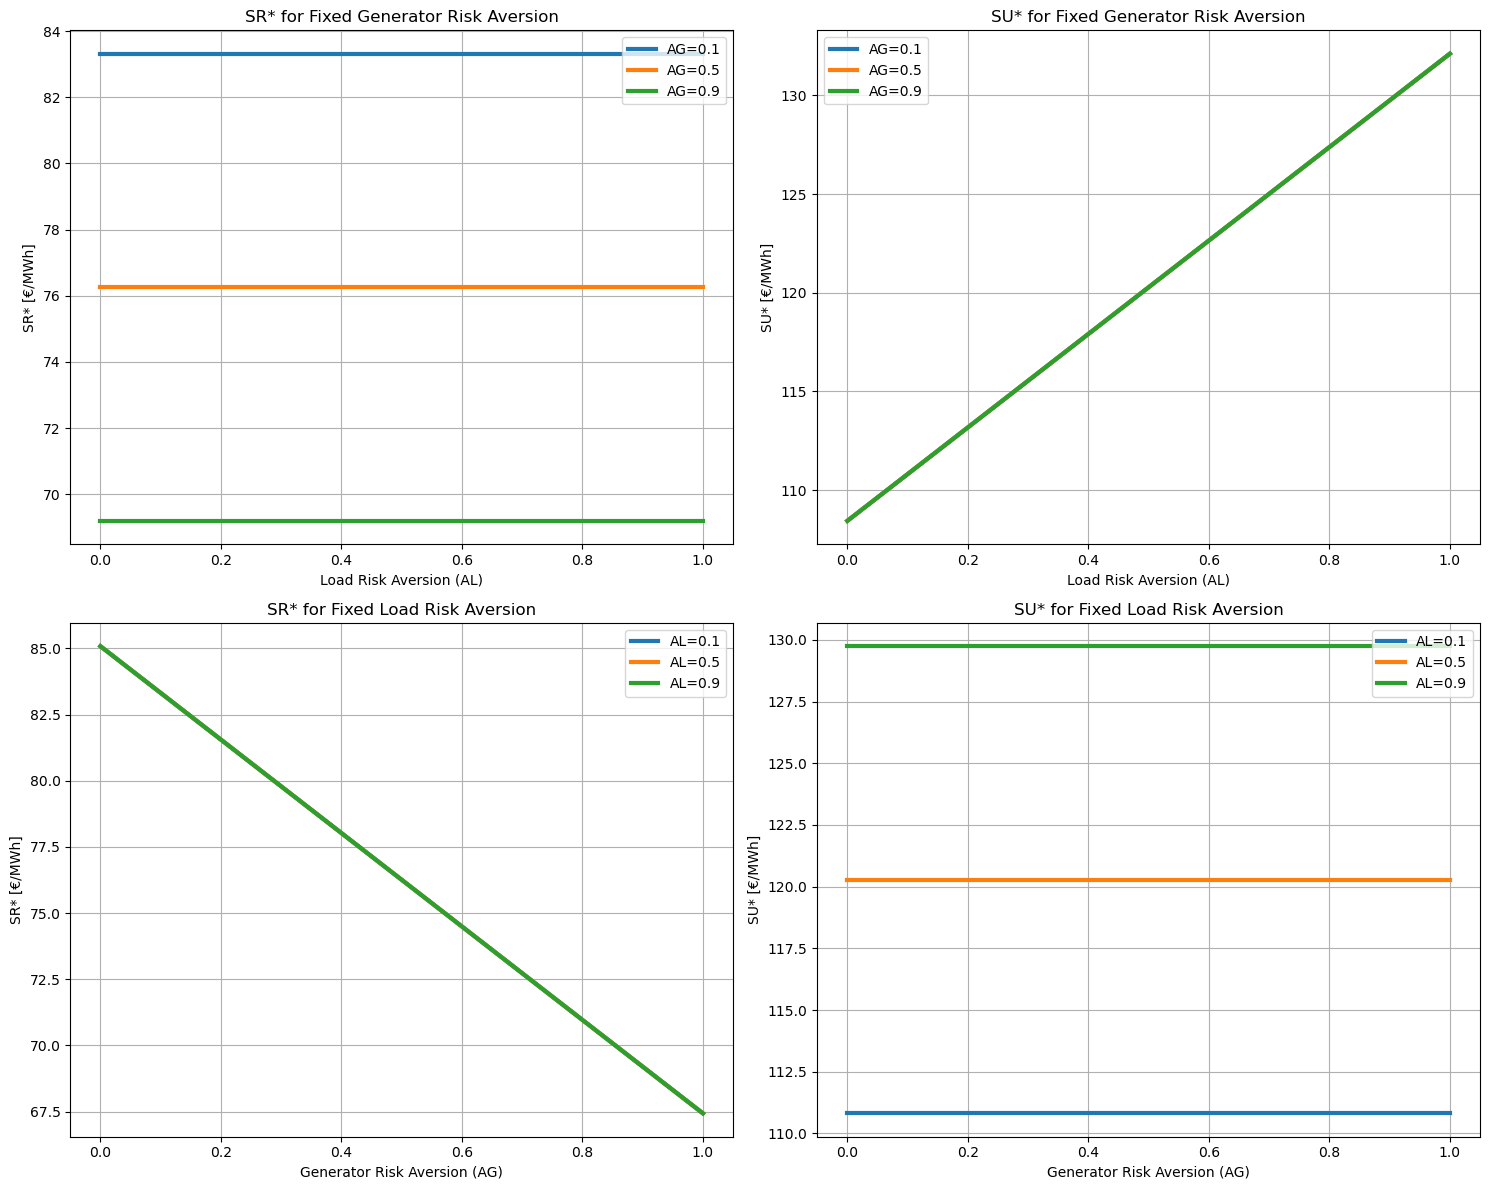

In [9]:
# For now exclude optimal values 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Fixed AG, varying AL (SR*)
for ag in fixed_profiles_AG:
    mask = df_uniform_AG['AG'] == ag
    ax1.plot(df_uniform_AG[mask]['AL'], 
             df_uniform_AG[mask]['SR'],
             label=f'AG={ag:.1f}',
             linewidth=3),
ax1.set_xlabel('Load Risk Aversion (AL)')
ax1.set_ylabel('SR* [€/MWh]')
ax1.set_title('SR* for Fixed Generator Risk Aversion')
ax1.legend()
ax1.grid(True)

# 2. Fixed AG, varying AL (SU*)
for ag in fixed_profiles_AG:
    mask = df_uniform_AG['AG'] == ag
    ax2.plot(df_uniform_AG[mask]['AL'], 
             df_uniform_AG[mask]['SU'],
             label=f'AG={ag:.1f}',
             linewidth=3)
ax2.set_xlabel('Load Risk Aversion (AL)')
ax2.set_ylabel('SU* [€/MWh]')
ax2.set_title('SU* for Fixed Generator Risk Aversion')
ax2.legend()
ax2.grid(True)

# 3. Fixed AL, varying AG (SR*)
for al in fixed_profiles_AL:
    mask = df_uniform_AL['AL'] == al
    ax3.plot(df_uniform_AL[mask]['AG'], 
             df_uniform_AL[mask]['SR'],
             label=f'AL={al:.1f}',
             linewidth=3)
ax3.set_xlabel('Generator Risk Aversion (AG)')
ax3.set_ylabel('SR* [€/MWh]')
ax3.set_title('SR* for Fixed Load Risk Aversion')
ax3.legend()
ax3.grid(True)

# 4. Fixed AL, varying AG (SU*)
for al in fixed_profiles_AL:
    mask = df_uniform_AL['AL'] == al
    ax4.plot(df_uniform_AL[mask]['AG'], 
             df_uniform_AL[mask]['SU'],
             label=f'AL={al:.1f}',
             linewidth=3)
ax4.set_xlabel('Generator Risk Aversion (AG)')
ax4.set_ylabel('SU* [€/MWh]')
ax4.set_title('SU* for Fixed Load Risk Aversion')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


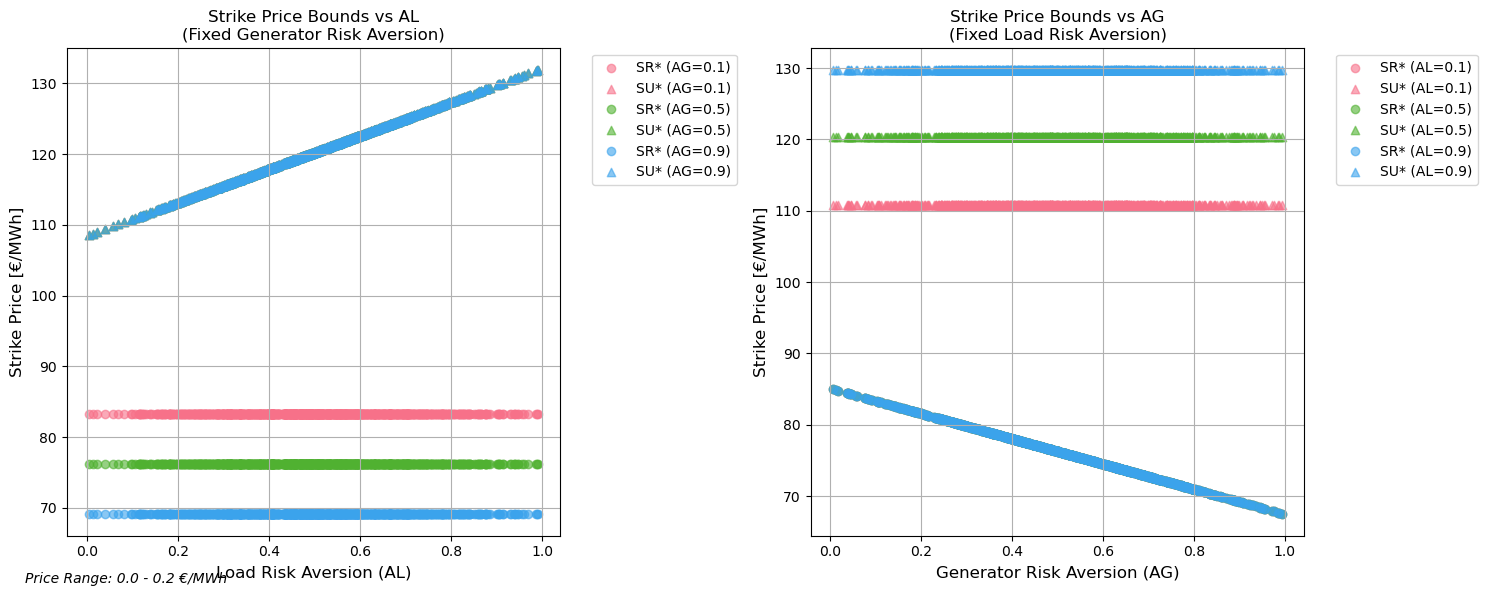

In [10]:
# Set style and color palette
colors = sns.color_palette("husl", n_colors=len(fixed_profiles_AG))

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Fixed AG, varying AL
for i, ag in enumerate(fixed_profiles_AG):
    mask = df_sampled_AG['AG'] == ag
    # Plot SR* points
    ax1.scatter(df_sampled_AG[mask]['AL'], 
                df_sampled_AG[mask]['SR'],
                alpha=0.6,
                color=colors[i],
                marker='o',
                label=f'SR* (AG={ag:.1f})')
    # Plot SU* points
    ax1.scatter(df_sampled_AG[mask]['AL'], 
                df_sampled_AG[mask]['SU'],
                alpha=0.6,
                color=colors[i],
                marker='^',
                label=f'SU* (AG={ag:.1f})')

ax1.set_xlabel('Load Risk Aversion (AL)', fontsize=12)
ax1.set_ylabel('Strike Price [€/MWh]', fontsize=12)
ax1.set_title('Strike Price Bounds vs AL\n(Fixed Generator Risk Aversion)', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# 2. Fixed AL, varying AG
for i, al in enumerate(fixed_profiles_AL):
    mask = df_sampled_AL['AL'] == al
    # Plot SR* points
    ax2.scatter(df_sampled_AL[mask]['AG'], 
                df_sampled_AL[mask]['SR'],
                alpha=0.6,
                color=colors[i],
                marker='o',
                label=f'SR* (AL={al:.1f})')
    # Plot SU* points
    ax2.scatter(df_sampled_AL[mask]['AG'], 
                df_sampled_AL[mask]['SU'],
                alpha=0.6,
                color=colors[i],
                marker='^',
                label=f'SU* (AL={al:.1f})')

ax2.set_xlabel('Generator Risk Aversion (AG)', fontsize=12)
ax2.set_ylabel('Strike Price [€/MWh]', fontsize=12)
ax2.set_title('Strike Price Bounds vs AG\n(Fixed Load Risk Aversion)', fontsize=12)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

# Add price range annotation
price_range = f"Price Range: {prices_df.min().min():.1f} - {prices_df.max().max():.1f} €/MWh"
fig.text(0.02, 0.02, price_range, fontsize=10, style='italic')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure
plt.savefig('strike_prices_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
class NashBargaining:
    def __init__(self, input_data,fixed_contract_amount=None):
        """Initialize contract negotiation model with loaded scenarios.
        
        Args:
            input_data: Input data object containing loaded scenarios and parameters
        """        
        self.data = input_data
        self.results = Expando()
        self.variables = Expando()
        self.constraints = Expando()
        self.fixed_contract_amount = fixed_contract_amount  # Fixed M value

        
        self._build_model()

    def _get_S(self, s=None):
        """Helper method to access strike price variable S.
        
        Args:
            s: Scenario index (optional, required if S is scenario-indexed)
            
        Returns:
            Gurobi variable (S[s] if indexed, S if scalar)
        """
        if self.data.Scenarios_S:
            if s is None:
                raise ValueError("Scenario index required when S is scenario-indexed")
            return self.variables.S[s]
        else:
            return self.variables.S

    def _get_M(self, s=None):
        """Helper method to access contract amount variable M.
        
        Args:
            s: Scenario index (optional, required if M is scenario-indexed)
            
        Returns:
            Gurobi variable (M[s] if indexed, M if scalar)
        """
        if self.data.Scenarios_M:
            if s is None:
                raise ValueError("Scenario index required when M is scenario-indexed")
            return self.variables.M[s]
        else:
            return self.variables.M

    def _build_variables(self):
        """Build optimization variables for contract negotiation."""
        EPS = 1e-8  # Small positive number for numerical stability
        
        # Define log-based auxiliary variables
        for name in ['arg_G', 'arg_L', 'log_arg_G', 'log_arg_L']:
              setattr(self.variables, name, self.model.addVar(lb=EPS, name=name))

        # Define core optimization variables (per scenario or scalar)
        if self.data.Scenarios_S:
            setattr(self.variables, 'S', self.model.addVars(self.data.SCENARIOS, lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))
        else: 
            setattr(self.variables, 'S', self.model.addVar(lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))

        if self.data.Scenarios_M:
            setattr(self.variables, 'M', self.model.addVars(self.data.SCENARIOS, lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))
        else:
            setattr(self.variables, 'M', self.model.addVar(lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))

        # Define auxiliary variables for optimization
        for name in ['zeta_G', 'zeta_L']:
            setattr(self.variables, name, self.model.addVar(name=f'Zeta_Auxillary_{name[-1]}', lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY))

        # Define scenario-based eta variables
        for name in ['eta_G', 'eta_L']:
            setattr(self.variables, name, self.model.addVars(self.data.SCENARIOS, name=f'Auxillary_Variable_{name[-1]}', lb=0, ub=gp.GRB.INFINITY))

        self.model.update()

    def _build_constraints(self):
        """Build constraints for contract negotiation."""
        # Strike price constraints (bounds already set in variable creation, but add explicit constraints if needed)
        if self.data.Scenarios_S:
            self.constraints.strike_price_constraint_min = self.model.addConstrs(
                (self._get_S(s) >= self.data.strikeprice_min for s in self.data.SCENARIOS), 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstrs(
                (self._get_S(s) <= self.data.strikeprice_max for s in self.data.SCENARIOS), 
                name='Strike_Price_Max')
        else:
            self.constraints.strike_price_constraint_min = self.model.addConstr(
                self._get_S() >= self.data.strikeprice_min, 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstr(
                self._get_S() <= self.data.strikeprice_max, 
                name='Strike_Price_Max')
        
        # Contract amount constraints
        # Contract amount constraints
        if self.fixed_contract_amount is not None:
            # Fix M to the specified value
            self.constraints.fixed_contract_amount = self.model.addConstr(
                self._get_M() == self.fixed_contract_amount,
                name='Fixed_Contract_Amount'
            )
        elif self.data.Scenarios_M:
            self.constraints.contract_amount_constraint_min = self.model.addConstrs(
                (self._get_M(s) >= self.data.contract_amount_min for s in self.data.SCENARIOS), 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstrs(
                (self._get_M(s) <= self.data.contract_amount_max for s in self.data.SCENARIOS), 
                name='Contract_Amount_Max')
        else:
            self.constraints.contract_amount_constraint_min = self.model.addConstr(
                self._get_M() >= self.data.contract_amount_min, 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstr(
                self._get_M() <= self.data.contract_amount_max, 
                name='Contract_Amount_Max')

        # Log constraints (on aggregate arguments)
        self.model.addGenConstrLog(self.variables.arg_G, self.variables.log_arg_G, 'log_G')
        self.model.addGenConstrLog(self.variables.arg_L, self.variables.log_arg_L, 'log_L')

        # Convert to numpy arrays for consistent indexing
        capture_rate_array = self.data.capture_rate
        price_G_array = self.data.price_G
        production_G_array = self.data.production_G
        load_scenarios_array = self.data.load_scenarios
        load_CR_array = self.data.load_CR
        price_L_array = self.data.price_L

        # Pre-compute constant terms for each scenario
        generator_const_per_scenario = (
            self.data.discount_factors_G_arr * capture_rate_array * price_G_array * production_G_array
        ).sum(axis=0) #- self.data.CAPEX  # Sum over time for each scenario

        load_const_per_scenario = (
            -self.data.discount_factors_L_arr * load_scenarios_array * load_CR_array * price_L_array
        ).sum(axis=0)  # Sum over time for each scenario

        # Generator eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )

        # Load eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )

        self.model.update()

    def _build_objective(self):
        """Build the objective function for contract negotiation."""
        # Pre-extract all data as numpy arrays
        prob_vals = self.data.PROB
        capture_rate_vals = self.data.capture_rate
        price_G_vals = self.data.price_G
        production_G_vals = self.data.production_G
        load_scenarios_vals = self.data.load_scenarios
        load_CR_vals = self.data.load_CR
        price_L_vals = self.data.price_L

        # Calculate expected utilities with contract
        eta_sum_G = gp.quicksum(self.data.PROB[s] * self.variables.eta_G[s] for s in self.data.SCENARIOS)
        eta_sum_L = gp.quicksum(self.data.PROB[s] * self.variables.eta_L[s] for s in self.data.SCENARIOS)

        # Build expected earnings expressions based on indexing configuration
        if not self.data.Scenarios_S and not self.data.Scenarios_M:
            # Both scalar - use original vectorized approach for efficiency
            gen_revenue_const = np.sum(prob_vals * capture_rate_vals * 
                            price_G_vals * production_G_vals * 
                            self.data.discount_factors_G_arr) #- self.data.CAPEX
            
            S_coeff_G = np.sum(prob_vals * self.data.discount_factors_G_arr)
            M_coeff_G = -np.sum(prob_vals * price_G_vals * self.data.discount_factors_G_arr)
            
            EuG = (gen_revenue_const + 
                    S_coeff_G * self.variables.S * self.variables.M +
                    M_coeff_G * self.variables.M)
            
            load_revenue_const = np.sum(prob_vals * load_scenarios_vals * 
                                    (- load_CR_vals * price_L_vals) * self.data.discount_factors_L_arr)
            
            S_coeff_L = -np.sum(prob_vals * self.data.discount_factors_L_arr)
            M_coeff_L = np.sum(prob_vals * price_L_vals * self.data.discount_factors_L_arr)
            
            EuL = (load_revenue_const + 
                S_coeff_L * self.variables.S * self.variables.M + 
                M_coeff_L * self.variables.M)

        elif self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr) #- self.data.CAPEX        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        elif self.data.Scenarios_S and not self.data.Scenarios_M:
            # Only S is scenario-indexed, M is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        else:  # not self.data.Scenarios_S and self.data.Scenarios_M
            # Only M is scenario-indexed, S is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)
        
        # CVaR terms
        CVaR_G = self.variables.zeta_G - (1/(1-self.data.alpha)) * eta_sum_G
        CVaR_L = self.variables.zeta_L - (1/(1-self.data.alpha)) * eta_sum_L

        # Utilities
        U_G = (1-self.data.A_G) * EuG + self.data.A_G * CVaR_G
        U_L = (1-self.data.A_L) * EuL + self.data.A_L * CVaR_L

        # Set objective based on bargaining power
        if self.data.tau_G == 1:
            self.model.setObjective(U_G - self.data.Zeta_G, GRB.MAXIMIZE)
            self.model.addConstr(U_L - self.data.Zeta_L >= 1e-8, "UL_non_negative")
        elif self.data.tau_L == 1:
            self.model.setObjective(U_L - self.data.Zeta_L, GRB.MAXIMIZE)
            self.model.addConstr(U_G - self.data.Zeta_G >= 1e-8, "UG_non_negative")
        else:
            # Nash bargaining solution
            self.model.addConstr(
                self.variables.arg_G == U_G - self.data.Zeta_G, 
                "arg_G_constr"
            )
            self.model.addConstr(
                self.variables.arg_L == U_L - self.data.Zeta_L,
                "arg_L_constr"
            )
            self.model.setObjective(
                self.data.tau_G * self.variables.log_arg_G + self.data.tau_L * self.variables.log_arg_L, 
                GRB.MAXIMIZE
            )

        self.model.update()

    def _calculate_revenues(self, strike_arr=None, amount_arr=None):
        """Calculate scenario-level revenues.

        Args:
            strike_arr: Array of strike prices (length = num_scenarios)
            amount_arr: Array of contract amounts (length = num_scenarios)

        Returns:
            Tuple of (EuG, SMG, EuL, SML) arrays (each length = num_scenarios)
        """
        num_s = self.data.num_scenarios
        
        # Read decision values if not provided
        if strike_arr is None:
            if self.data.Scenarios_S:
                strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
            else:
                strike_arr = np.full(num_s, self._get_S().x)
        
        if amount_arr is None:
            if self.data.Scenarios_M:
                amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
            else:
                amount_arr = np.full(num_s, self._get_M().x)

        # Flatten discount factors
        disc_G = self.data.discount_factors_G_arr.flatten()
        disc_L = self.data.discount_factors_L_arr.flatten()

        price_G = self.data.price_G  # shape (T, S)
        price_L = self.data.price_L

        EuG = np.array(self.data.net_earnings_no_contract_priceG_G)  # per-scenario base earnings
        EuL = np.array(self.data.net_earnings_no_contract_priceL_L)

        SMG = np.zeros(num_s)
        SML = np.zeros(num_s)

        # Per-scenario loop
        for s in range(num_s):
            # Generator side: sum over time
            SMG[s] = np.sum((strike_arr[s] - price_G[:, s]) * amount_arr[s] * disc_G)
            # Load side
            SML[s] = np.sum((price_L[:, s] - strike_arr[s]) * amount_arr[s] * disc_L)

        return EuG, SMG, EuL, SML

    def _build_model(self):
        """Initialize and build the complete optimization model."""
        self.model = gp.Model(name='Nash Bargaining Model')
        
        # Set model parameters
        params = {
            'NonConvex': 2,
            'FeasibilityTol': 1e-6,
            'OutputFlag': 0,
            'TimeLimit': 100,
            'ObjScale': 1e-6
            }

        for key, value in params.items():
            self.model.setParam(key, value)
        
        # Build model components
        self._build_variables()
        self._build_constraints()
        self._build_objective()

    def _save_results(self):
        """Save optimization results, including per-scenario revenues and probability-weighted averages."""
        # Save objective
        self.results.objective_value = self.model.ObjVal

        # Extract per-scenario decision values
        num_s = self.data.num_scenarios
        
        if self.data.Scenarios_S:
            strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
        else:
            strike_arr = np.full(num_s, self._get_S().x)
            
        if self.data.Scenarios_M:
            amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
        else:
            amount_arr = np.full(num_s, self._get_M().x)

        # Save per-scenario values (convert strike to €/MWh)
        self.results.strike_price_per_scenario = strike_arr * 1e3
        self.results.contract_amount_per_scenario = amount_arr
        self.results.contract_amount_hour_per_scenario = (amount_arr / 8760.0) * 1e3

        # Calculate revenues per scenario
        EuG, SMG, EuL, SML = self._calculate_revenues(strike_arr=strike_arr, amount_arr=amount_arr)

        total_earnings_G = EuG + SMG
        total_earnings_L = EuL + SML

        # Save per-scenario revenues
        self.results.earnings_G_per_scenario = total_earnings_G
        self.results.earnings_L_per_scenario = total_earnings_L

        # Probability-weighted averages
        probs = np.array(self.data.PROB)
        self.results.avg_strike_price = (probs * strike_arr).sum() * 1e3
        self.results.avg_contract_amount = (probs * amount_arr).sum()
        self.results.avg_contract_amount_hour = (self.results.avg_contract_amount / 8760.0) * 1e3

        self.results.avg_earnings_G = (probs * total_earnings_G).sum()
        self.results.avg_earnings_L = (probs * total_earnings_L).sum()

        # CVaR on resulting distributions (ex-post / recomputed)
        self.results.CVaRG_expost = calculate_cvar_left(total_earnings_G, probs, self.data.alpha)
        self.results.CVaRL_expost = calculate_cvar_left(total_earnings_L, probs, self.data.alpha)

        # Utilities using ex-post CVaR
        utility_G_expost = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * self.results.CVaRG_expost
        utility_L_expost = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * self.results.CVaRL_expost

        self.results.utility_G_expost = utility_G_expost
        self.results.utility_L_expost = utility_L_expost

        # ---- Model-consistent CVaR and utility (use zeta and eta variable values) ----
        # Compute CVaR from model variables: zeta - (1/(1-alpha)) * sum(p_s * eta_s)
        eta_G_sum_model = sum(self.data.PROB[s] * self.variables.eta_G[s].x for s in self.data.SCENARIOS)
        eta_L_sum_model = sum(self.data.PROB[s] * self.variables.eta_L[s].x for s in self.data.SCENARIOS)

        CVaR_G_model = self.variables.zeta_G.x - (1.0 / (1.0 - self.data.alpha)) * eta_G_sum_model
        CVaR_L_model = self.variables.zeta_L.x - (1.0 / (1.0 - self.data.alpha)) * eta_L_sum_model

        self.results.CVaRG_model = CVaR_G_model
        self.results.CVaRL_model = CVaR_L_model

        # Model-consistent utilities: expected earnings is the same avg_earnings computed above
        utility_G_model = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * CVaR_G_model
        utility_L_model = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * CVaR_L_model

        self.results.utility_G_model = utility_G_model
        self.results.utility_L_model = utility_L_model

        # Threat points (from data)
        self.results.Zeta_G = self.data.Zeta_G
        self.results.Zeta_L = self.data.Zeta_L

        # Nash product (use model-consistent utilities for correctness)
        self.results.Nash_Product_model = (utility_G_model - self.results.Zeta_G) * (utility_L_model - self.results.Zeta_L)
        self.results.Nash_Product_expost = (utility_G_expost - self.results.Zeta_G) * (utility_L_expost - self.results.Zeta_L)

        # Sanity checks / warnings
        tol = 1e-6
        if utility_G_model + tol < self.results.Zeta_G:
            print("WARNING: model-consistent utility_G is below threat point (Zeta_G).")
        if utility_L_model + tol < self.results.Zeta_L:
            print("WARNING: model-consistent utility_L is below threat point (Zeta_L).")

        # If ex-post utility is below threat point, warn and show both values for debugging
        if utility_G_expost + tol < self.results.Zeta_G or utility_L_expost + tol < self.results.Zeta_L:
            print("WARNING: ex-post recomputed utility is below threat point. This indicates a mismatch between the model CVaR representation and the ex-post CVaR computation.")
            print(f"Utility_G_model={utility_G_model:.6f}, Utility_G_expost={utility_G_expost:.6f}, Zeta_G={self.results.Zeta_G:.6f}")
            print(f"Utility_L_model={utility_L_model:.6f}, Utility_L_expost={utility_L_expost:.6f}, Zeta_L={self.results.Zeta_L:.6f}")

        # Save final reported utilities (use model-consistent by default)
        self.results.utility_G = utility_G_model
        self.results.utility_L = utility_L_model
        self.results.CVaRG = CVaR_G_model
        self.results.CVaRL = CVaR_L_model
    
    def run(self):
        """Run the optimization model."""
        self.model.optimize()

        if self.model.status == GRB.OPTIMAL:
            self._save_results()
            self.display_results()
            self.results.optimal = True
        else:
            self.results.optimal = False
            raise RuntimeError(f"Optimization of {self.model.ModelName} was not successful")

    def display_results(self):
        """Display optimization results."""
        print("\n-------------------   RESULTS GUROBI  -------------------")
        results = {
            "Optimal Objective Value (Log)": self.results.objective_value,
            "Avg Strike Price (EUR/MWh)": self.results.avg_strike_price,
            "Lower Strike Price SR* (EUR/MWh)": self.data.SR_star_new,
            "Upper Strike Price SU* (EUR/MWh)": self.data.SU_star_new,
            "Avg Contract Amount (GWh/year)": self.results.avg_contract_amount,
            "Avg Contract Amount (MWh)": self.results.avg_contract_amount_hour,
            "Avg Earnings G": self.results.avg_earnings_G,
            "Avg Earnings L": self.results.avg_earnings_L,
            "CVaR G": self.results.CVaRG,
            "CVaR L": self.results.CVaRL,
            "Utility G": self.results.utility_G,
            "Utility L": self.results.utility_L,
            "Threat Point G": self.results.Zeta_G,
            "Threat Point L": self.results.Zeta_L,
            "Nash Product": self.results.Nash_Product_model
        }
        for key, value in results.items():
            try:
                print(f"{key}: {value:.5f}")
            except Exception:
                print(f"{key}: {value}")

In [12]:
class ContractData:
    def __init__(self, scenario_path, time_horizon, num_scenarios, discount_rate_G=0.02, discount_rate_L=0.05, alpha=0.95,
                 strikeprice_min=0, strikeprice_max=1000, contract_amount_min=0, contract_amount_max=1000,
                 A_G=0.5, A_L=0.5, tau_G=0.5, tau_L=0.5, Scenarios_S=False, Scenarios_M=False,
                 Discount=True, K_G_lambda_Sigma=0, K_L_lambda_Sigma=0):
        """Initialize data for contract negotiation.

        Args:
            scenario_path (str): Path to scenario data files
            time_horizon (int): Time horizon in years
            num_scenarios (int): Number of scenarios
            discount_rate_G (float): Generator's discount rate (default: 0.02)
            discount_rate_L (float): Load's discount rate (default: 0.05)
            alpha (float): CVaR confidence level (default: 0.95)
            strikeprice_min (float): Minimum strike price (default: 0)
            strikeprice_max (float): Maximum strike price (default: 1000)
            contract_amount_min (float): Minimum contract amount (default: 0)
            contract_amount_max (float): Maximum contract amount (default: Capacity * 8760 / 1000)
            A_G (float): Generator's risk aversion parameter (default: 0.5)
            A_L (float): Load's risk aversion parameter (default: 0.5)
            tau_G (float): Generator's bargaining power (default: 0.5)
            tau_L (float): Load's bargaining power (default: 0.5)
            Scenarios_S (bool): Strike Price indexed by scenarios (default: False)
            Scenarios_M (bool): Contract Amount M indexed by scenarios (default: False)
            Discount (bool): Use discounting for strike price borders (default: True)
            K_G_lambda_Sigma (float): Generator's lambda adjustment constant (default: 0)
            K_L_lambda_Sigma (float): Load's lambda adjustment constant (default: 0)
        """
        # Store parameters
        self.time_horizon = time_horizon
        self.num_scenarios = num_scenarios
        self.alpha = alpha
        self.A_G = A_G
        self.A_L = A_L
        self.tau_G = tau_G
        self.tau_L = tau_L
        self.Scenarios_S = Scenarios_S
        self.Scenarios_M = Scenarios_M
        self.Discount = Discount
        self.K_G_lambda_Sigma = K_G_lambda_Sigma
        self.K_L_lambda_Sigma = K_L_lambda_Sigma
        self.CAPEX_MW  = 1.18  # mio Eur/MW

        # Contract limits
        self.strikeprice_min = strikeprice_min
        self.strikeprice_max = strikeprice_max
        self.contract_amount_min = contract_amount_min
        self.contract_amount_max = contract_amount_max
        self.capacity_MW = self.contract_amount_max * 1000 / 8760  # MW
        #self.CAPEX   = self.CAPEX_MW * self.capacity_MW  # Mio EUR


        # Calculate discount factors
        self.discount_factors_G_arr = (1 / (1 + discount_rate_G) ** np.arange(time_horizon))[:, None]
        self.discount_factors_L_arr = (1 / (1 + discount_rate_L) ** np.arange(time_horizon))[:, None]

        # Load scenario data
        self._load_scenarios(scenario_path)

        # Calculate derived values
        self._calculate_derived_values()

        # Calculate strike price borders
        self._calculate_strike_price_borders()
        
    def _load_scenarios(self, scenario_path):
        """Load all scenario data from files."""
        scenario_pattern = f"{{type}}_scenarios_reduced_{20}y_{self.num_scenarios}s.csv"
        
        # Load price scenarios
        self.price_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='price')}", index_col=0).values[:self.time_horizon, :]
        self.price_L = self.price_G.copy()  # Assuming same prices for both parties
        
        # Load production scenarios
        self.production_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='production')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load capture rate scenarios
        self.capture_rate = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='capture_rate')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load load scenarios
        self.load_scenarios = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load')}", 
                                        index_col=0).values[:self.time_horizon, :]
        
        # Load load capture rate scenarios
        self.load_CR = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load_capture_rate')}", 
                                 index_col=0).values[:self.time_horizon, :]
        
        # Load probabilities
        self.PROB = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='probabilities')}", 
                              index_col=0).values.flatten()
        
    def _calculate_derived_values(self):
        """Calculate derived values needed for optimization."""
        # Time indices
        self.TIME = range(self.time_horizon)
        self.SCENARIOS = range(self.num_scenarios)
        
        # Calculate no-contract earnings
        self.net_earnings_no_contract_priceG_G = (self.discount_factors_G_arr * self.capture_rate * self.price_G * self.production_G).sum(axis=0) #- self.CAPEX
        self.net_earnings_no_contract_priceL_L = (-self.discount_factors_L_arr * self.load_scenarios * self.load_CR * self.price_L).sum(axis=0)
        
        # Calculate CVaR for no-contract case
        self.CVaR_no_contract_G = calculate_cvar_left(self.net_earnings_no_contract_priceG_G, self.PROB, self.alpha)
        self.CVaR_no_contract_L = calculate_cvar_left(self.net_earnings_no_contract_priceL_L, self.PROB, self.alpha)
        
        # Calculate threat points (Zeta values)
        self.Zeta_G = ((1 - self.A_G) * (self.PROB * self.net_earnings_no_contract_priceG_G).sum() + self.A_G * self.CVaR_no_contract_G)
        self.Zeta_L = ((1 - self.A_L) * (self.PROB * self.net_earnings_no_contract_priceL_L).sum() + self.A_L * self.CVaR_no_contract_L)
        
        # Calculate expected price
        self.expected_price = (self.PROB * self.price_G.mean(axis=0)).sum()
        
        # Calculate capture price for generator
        self.Capture_price_G_avg = ((self.capture_rate * self.price_G).sum(axis=0) / self.capture_rate.sum(axis=0))

        # Calculate expected lambda sum (needed for strike price borders)
        self.expected_lambda_sum_true = self.price_G.sum(axis=0)  # Sum over time for each scenario

    def _calculate_strike_price_borders(self):
        """Calculate strike price borders (SR* and SU*) based on CVaR calculations."""
        time_periods = self.price_G.shape[0]

        if self.Discount:
            # Use discounted prices
            discounted_prices_G = (self.price_G * self.discount_factors_G_arr)
            discounted_prices_L = (self.price_L * self.discount_factors_L_arr)
            
            # Sum over time for each scenario
            lambda_sum_G_discounted = discounted_prices_G.sum(axis=0)
            lambda_sum_L_discounted = discounted_prices_L.sum(axis=0)
            
            # Expected values with discounting
            expected_lambda_sum_discounted_G = (self.PROB * lambda_sum_G_discounted).sum()
            expected_lambda_sum_discounted_L = (self.PROB * lambda_sum_L_discounted).sum()

            # Get masks using discounted earnings
            ord_G, bidx_G = _left_tail_mask(
                self.net_earnings_no_contract_priceG_G,
                self.PROB, 
                self.alpha
            )

                # Get masks using discounted earnings
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB, 
                self.alpha
            )

            # Calculate CVaR terms with discounted values
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_G_discounted,  # Use discounted sum
                ord_G, bidx_G, 
                self.alpha
            )

            tail_L = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_L_discounted,  # Use discounted sum
                ord_L, bidx_L, 
                self.alpha
            )

            self.term2_G_new =  (
                ((1-self.A_G) * expected_lambda_sum_discounted_G + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / ( self.discount_factors_G_arr.sum())

            # Calculate terms with discounted values
            self.term3_L_new = (
                ((1-self.A_L) * expected_lambda_sum_discounted_L + 
                self.K_L_lambda_Sigma) + 
                self.A_L * tail_L
            ) / ( self.discount_factors_L_arr.sum())
        else:
           

            ord_G, bidx_G = _left_tail_mask(
                    self.net_earnings_no_contract_priceG_G,
                    self.PROB, 
                    self.alpha
                )

                # Get masks using discounted earnings
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB, 
                self.alpha
            )

            # Calculate CVaR terms with discounted values
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                self.expected_lambda_sum_true,  # Use discounted sum
                ord_G, bidx_G, 
                self.alpha
            )
            
            tail_L = _left_tail_weighted_sum(
                self.PROB,
                self.expected_lambda_sum_true,  # Use discounted sum
                ord_L, bidx_L, 
                self.alpha
            )
            
            self.term2_G_new = (
                ((1-self.A_G) * self.expected_lambda_sum_true + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / time_periods
            self.term3_L_new = (self.expected_lambda_sum_true
                                + self.A_L * tail_L
                            + self.K_L_lambda_Sigma  - self.A_L * self.expected_lambda_sum_true )  / time_periods   # SR* numerator for LSE
            
        
        # Calculate SR* using Equation (27) - Minimum of the relevant terms
        self.SR_star_new = np.min([self.term2_G_new, self.term3_L_new])*1e3  # Convert from $/GWh to $/MWh
        # Calculate SU* using Equation (28) - Maximum of the relevant terms
        self.SU_star_new = np.max([self.term2_G_new, self.term3_L_new])*1e3  # Convert from $/GWh to $/MWh


        print(f"Initial Threshold at M=0 SR* [EUR/MWh]: {self.SR_star_new*1e3:.3f}")
        print(f"Initial Threshold at M=0 SU* [EUR/MWh]: {self.SU_star_new*1e3:.3f}")

In [13]:
# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.03
discount_rate_L = 0.04
A_G = 0.5
A_L = 0.9 


# Initialize contract data
contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=0.5,  # Generator's bargaining power
    tau_L=0.5,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
# Initialize and run Nash Bargaining model
model = NashBargaining(contract_data)
model.run()

Initial Threshold at M=0 SR* [EUR/MWh]: 76305.025
Initial Threshold at M=0 SU* [EUR/MWh]: 102497.364
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.67102
Avg Strike Price (EUR/MWh): 94.50843
Lower Strike Price SR* (EUR/MWh): 76.30503
Upper Strike Price SU* (EUR/MWh): 102.49736
Avg Contract Amount (GWh/year): 141.51835
Avg Contract Amount (MWh): 16.15506
Avg Earnings G: 93.70937
Avg Earnings L: -199.42288
CVaR G: 67.14073
CVaR L: -204.82008
Utility G: 80.42505
Utility L: -204.28036
Threat Point G: 65.37414
Threat Point L: -218.16260
Nash Product: 208.94034


In [14]:
model.data.contract_amount_max

262.8

# Distribution of strike prices and contract amounts

Initial Threshold at M=0 SR* [EUR/MWh]: 76305.025
Initial Threshold at M=0 SU* [EUR/MWh]: 102497.364
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.83333
Avg Strike Price (EUR/MWh): 101.83996
Lower Strike Price SR* (EUR/MWh): 76.30503
Upper Strike Price SU* (EUR/MWh): 102.49736
Avg Contract Amount (GWh/year): 185.08138
Avg Contract Amount (MWh): 21.12801
Avg Earnings G: 97.10497
Avg Earnings L: -201.83321
CVaR G: 69.04831
CVaR L: -201.83327
Utility G: 83.07664
Utility L: -201.83326
Threat Point G: 65.37414
Threat Point L: -218.16260
Nash Product: 289.07018
STRIKE PRICE STATISTICS (EUR/MWh)
Expected Value (Probability-Weighted): 101.84
Standard Deviation:                    22.93
Minimum:                               40.00
Maximum:                               130.00
Range:                                 90.00

CONTRACT AMOUNT STATISTICS (MWh)
Expected Value (Pr

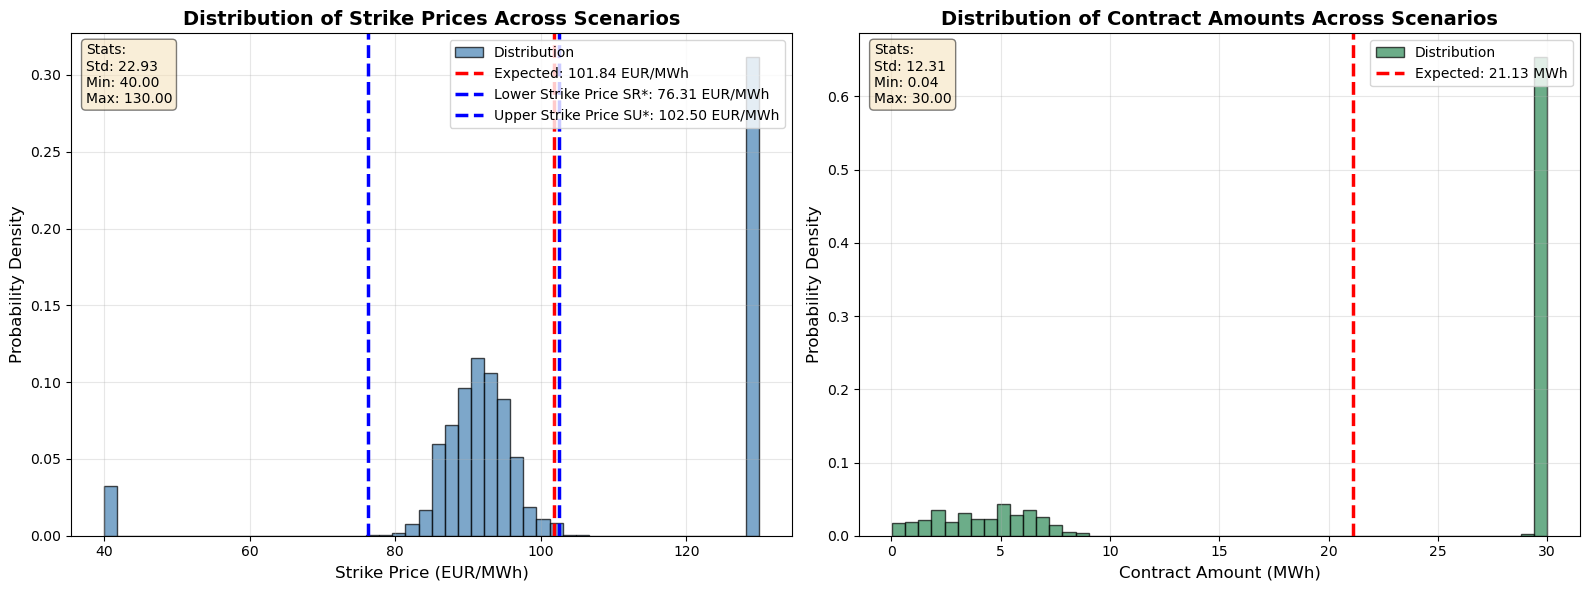

In [15]:
# Extract data from model results
Scenarios_S = True
Scenarios_M = True
contract_data_scen_all = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=0.5,  # Generator's bargaining power
    tau_L=0.5,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
model = NashBargaining(contract_data_scen_all)
model.run()
# Initialize contract

strike_prices = model.results.strike_price_per_scenario  # EUR/MWh
contract_amounts_gwh = model.results.contract_amount_per_scenario  # GWh/year
contract_amounts = model.results.contract_amount_hour_per_scenario  # MWh (hourly average)
probabilities = contract_data_scen_all.PROB

# Calculate expected values (probability-weighted)
expected_strike = model.results.avg_strike_price  # EUR/MWh
expected_amount = model.results.avg_contract_amount_hour  # MWh
SR_star = contract_data_scen_all.SR_star_new
SU_star = contract_data_scen_all.SU_star_new


# Print summary statistics
print("=" * 70)
print("STRIKE PRICE STATISTICS (EUR/MWh)")
print("=" * 70)
print(f"Expected Value (Probability-Weighted): {expected_strike:.2f}")
print(f"Standard Deviation:                    {strike_prices.std():.2f}")
print(f"Minimum:                               {strike_prices.min():.2f}")
print(f"Maximum:                               {strike_prices.max():.2f}")
print(f"Range:                                 {strike_prices.max() - strike_prices.min():.2f}")

print("\n" + "=" * 70)
print("CONTRACT AMOUNT STATISTICS (MWh)")
print("=" * 70)
print(f"Expected Value (Probability-Weighted): {expected_amount:.2f}")
print(f"Standard Deviation:                    {contract_amounts.std():.2f}")
print(f"Minimum:                               {contract_amounts.min():.2f}")
print(f"Maximum:                               {contract_amounts.max():.2f}")
print(f"Range:                                 {contract_amounts.max() - contract_amounts.min():.2f}")
print("=" * 70)

# Create figure with two histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Strike Price Distribution
# Use probability weights for histogram
ax1.hist(strike_prices, bins=50, weights=probabilities, alpha=0.7, color='steelblue', 
         edgecolor='black', label='Distribution')
ax1.axvline(expected_strike, color='red', linestyle='--', linewidth=2.5, 
            label=f'Expected: {expected_strike:.2f} EUR/MWh')
ax1.axvline(SR_star, color='blue', linestyle='--', linewidth=2.5, 
            label=f'Lower Strike Price SR*: {SR_star:.2f} EUR/MWh')
ax1.axvline(SU_star, color='blue', linestyle='--', linewidth=2.5, 
            label=f'Upper Strike Price SU*: {SU_star:.2f} EUR/MWh')

# Add text box with statistics
stats_text_strike = f'Stats:\nStd: {strike_prices.std():.2f}\nMin: {strike_prices.min():.2f}\nMax: {strike_prices.max():.2f}'
ax1.text(0.02, 0.98, stats_text_strike, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.set_xlabel('Strike Price (EUR/MWh)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title('Distribution of Strike Prices Across Scenarios', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Contract Amount Distribution
# Use probability weights for histogram
ax2.hist(contract_amounts, bins=50, weights=probabilities, alpha=0.7, color='seagreen', 
         edgecolor='black', label='Distribution')
ax2.axvline(expected_amount, color='red', linestyle='--', linewidth=2.5, 
            label=f'Expected: {expected_amount:.2f} MWh')


# Add text box with statistics
stats_text_amount = f'Stats:\nStd: {contract_amounts.std():.2f}\nMin: {contract_amounts.min():.2f}\nMax: {contract_amounts.max():.2f}'
ax2.text(0.02, 0.98, stats_text_amount, transform=ax2.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.set_xlabel('Contract Amount (MWh)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.set_title('Distribution of Contract Amounts Across Scenarios', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Distribution with Fixed Contract Amount (M scalar, S indexed by scenarios)

This section shows the case where the contract amount M is fixed across all scenarios, but the strike price S varies by scenario (Scenarios_S=True, Scenarios_M=False).

Initial Threshold at M=0 SR* [EUR/MWh]: 78103.945
Initial Threshold at M=0 SU* [EUR/MWh]: 96833.876
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.39536
Avg Strike Price (EUR/MWh): 89.26615
Lower Strike Price SR* (EUR/MWh): 78.10394
Upper Strike Price SU* (EUR/MWh): 96.83388
Avg Contract Amount (GWh/year): 262.80000
Avg Contract Amount (MWh): 30.00000
Avg Earnings G: 89.71274
Avg Earnings L: -195.38127
CVaR G: 61.62224
CVaR L: -195.38127
Utility G: 78.47654
Utility L: -195.38127
Threat Point G: 67.04714
Threat Point L: -205.91438
Nash Product: 120.38705

FIXED CONTRACT AMOUNT, VARYING STRIKE PRICE
Fixed Contract Amount (MWh):           30.00
Expected Strike Price (EUR/MWh):       89.27
Strike Price Std Dev:                  5.29
Strike Price Range:                    [75.38, 104.38]
SR* (Lower Bound):                     78.10
SU* (Upper Bound):                   

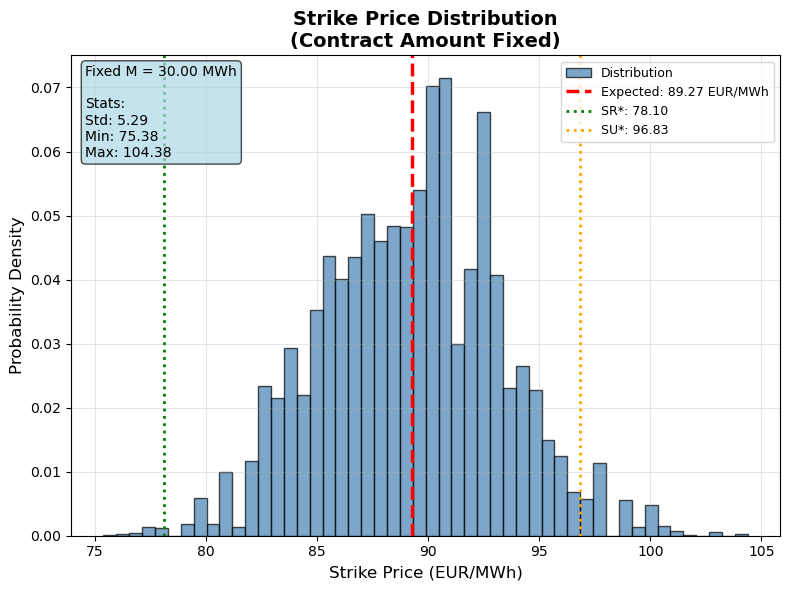

In [16]:
# Configuration: Fixed M, Varying S
contract_data_M_fixed = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=0.4,  # Generator's risk aversion
    A_L=0.6,  # Load's risk aversion
    tau_G=0.5,  # Generator's bargaining power
    tau_L=0.5,   # Load's bargaining power
    Scenarios_S= True,
    Scenarios_M= False,
)

# Run Nash Bargaining model
model_fixed_M = NashBargaining(contract_data_M_fixed)
model_fixed_M.run()

# Extract data from model results
strike_prices_fixed_M = model_fixed_M.results.strike_price_per_scenario  # EUR/MWh (varying)
contract_amounts_fixed_M = model_fixed_M.results.contract_amount_hour_per_scenario  # MWh (all same value)
probabilities_fixed_M = contract_data_M_fixed.PROB

# Calculate expected values
expected_strike_fixed_M = model_fixed_M.results.avg_strike_price  # EUR/MWh
fixed_amount_value = model_fixed_M.results.avg_contract_amount_hour  # MWh (constant)
SR_star_fixed_M = contract_data_M_fixed.SR_star_new
SU_star_fixed_M = contract_data_M_fixed.SU_star_new

# Extract earnings
earnings_G_fixed_M = model_fixed_M.results.earnings_G_per_scenario
earnings_L_fixed_M = model_fixed_M.results.earnings_L_per_scenario
expected_earnings_G = model_fixed_M.results.avg_earnings_G
expected_earnings_L = model_fixed_M.results.avg_earnings_L

# Print summary statistics
print("\n" + "=" * 70)
print("FIXED CONTRACT AMOUNT, VARYING STRIKE PRICE")
print("=" * 70)
print(f"Fixed Contract Amount (MWh):           {fixed_amount_value:.2f}")
print(f"Expected Strike Price (EUR/MWh):       {expected_strike_fixed_M:.2f}")
print(f"Strike Price Std Dev:                  {strike_prices_fixed_M.std():.2f}")
print(f"Strike Price Range:                    [{strike_prices_fixed_M.min():.2f}, {strike_prices_fixed_M.max():.2f}]")
print(f"SR* (Lower Bound):                     {SR_star_fixed_M:.2f}")
print(f"SU* (Upper Bound):                     {SU_star_fixed_M:.2f}")
print("=" * 70)

# Create figure with three panels
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

# 1. Strike Price Distribution (varying)
ax1.hist(strike_prices_fixed_M, bins=50, weights=probabilities_fixed_M, alpha=0.7, 
         color='steelblue', edgecolor='black', label='Distribution')
ax1.axvline(expected_strike_fixed_M, color='red', linestyle='--', linewidth=2.5, 
            label=f'Expected: {expected_strike_fixed_M:.2f} EUR/MWh')
ax1.axvline(SR_star_fixed_M, color='green', linestyle=':', linewidth=2, 
            label=f'SR*: {SR_star_fixed_M:.2f}')
ax1.axvline(SU_star_fixed_M, color='orange', linestyle=':', linewidth=2, 
            label=f'SU*: {SU_star_fixed_M:.2f}')

# Add text box with statistics
stats_text_strike_fixed_M = f'Fixed M = {fixed_amount_value:.2f} MWh\n\nStats:\nStd: {strike_prices_fixed_M.std():.2f}\nMin: {strike_prices_fixed_M.min():.2f}\nMax: {strike_prices_fixed_M.max():.2f}'
ax1.text(0.02, 0.98, stats_text_strike_fixed_M, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

ax1.set_xlabel('Strike Price (EUR/MWh)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title('Strike Price Distribution\n(Contract Amount Fixed)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Distribution with Fixed Strike Price (S scalar, M indexed by scenarios)

This section shows the case where the strike price S is fixed across all scenarios, but the contract amount M varies by scenario (Scenarios_S=False, Scenarios_M=True).

Initial Threshold at M=0 SR* [EUR/MWh]: 76305.025
Initial Threshold at M=0 SU* [EUR/MWh]: 102497.364
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.80665
Avg Strike Price (EUR/MWh): 93.99286
Lower Strike Price SR* (EUR/MWh): 76.30503
Upper Strike Price SU* (EUR/MWh): 102.49736
Avg Contract Amount (GWh/year): 167.96269
Avg Contract Amount (MWh): 19.17382
Avg Earnings G: 96.56282
Avg Earnings L: -201.92721
CVaR G: 68.39933
CVaR L: -202.16695
Utility G: 82.48108
Utility L: -202.14298
Threat Point G: 65.37414
Threat Point L: -218.16260
Nash Product: 274.04684

FIXED STRIKE PRICE, VARYING CONTRACT AMOUNT
Fixed Strike Price (EUR/MWh):          93.99
Expected Contract Amount (MWh):        19.17
Contract Amount Std Dev:               5.65
Contract Amount Range:                 [0.00, 30.00]
SR* (Lower Bound):                     76.31
SU* (Upper Bound):                   

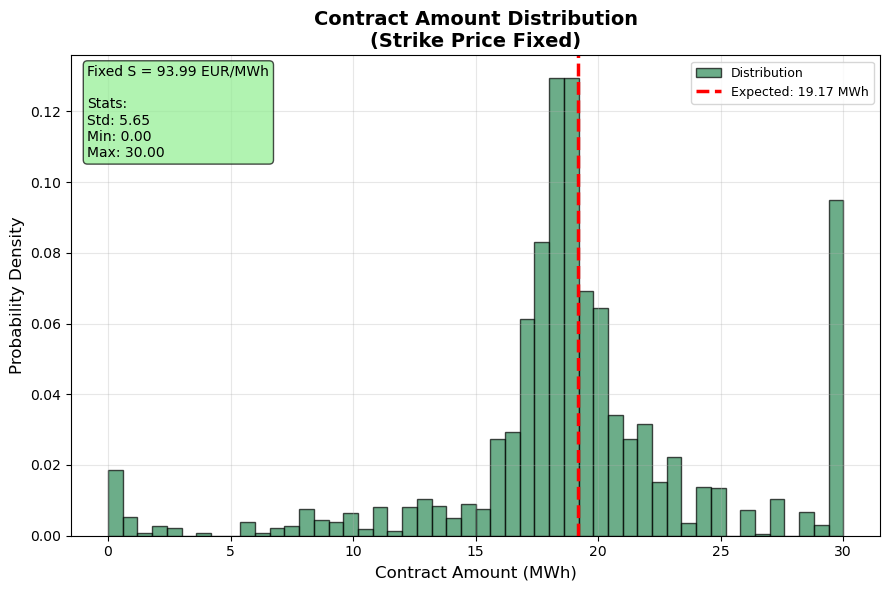

In [17]:
# Configuration: Fixed S, Varying M

# Initialize contract data with fixed S
contract_data_fixed_S = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max=generator_contract_capacity * 8760 * 1e-3,  # GWh/year
    A_G=A_G,
    A_L=A_L,
    tau_G=0.5,
    tau_L=0.5,
    Scenarios_S=False,
    Scenarios_M=True,
)

# Run Nash Bargaining model
model_fixed_S = NashBargaining(contract_data_fixed_S)
model_fixed_S.run()

# Extract data from model results
strike_prices_fixed_S = model_fixed_S.results.strike_price_per_scenario  # EUR/MWh (all same value)
contract_amounts_fixed_S = model_fixed_S.results.contract_amount_hour_per_scenario  # MWh (varying)
probabilities_fixed_S = contract_data_fixed_S.PROB

# Calculate expected values
fixed_strike_value = model_fixed_S.results.avg_strike_price  # EUR/MWh (constant)
expected_amount_fixed_S = model_fixed_S.results.avg_contract_amount_hour  # MWh
SR_star_fixed_S = contract_data_fixed_S.SR_star_new
SU_star_fixed_S = contract_data_fixed_S.SU_star_new

# Extract earnings
earnings_G_fixed_S = model_fixed_S.results.earnings_G_per_scenario
earnings_L_fixed_S = model_fixed_S.results.earnings_L_per_scenario
expected_earnings_G_S = model_fixed_S.results.avg_earnings_G
expected_earnings_L_S = model_fixed_S.results.avg_earnings_L

# Print summary statistics
print("\n" + "=" * 70)
print("FIXED STRIKE PRICE, VARYING CONTRACT AMOUNT")
print("=" * 70)
print(f"Fixed Strike Price (EUR/MWh):          {fixed_strike_value:.2f}")
print(f"Expected Contract Amount (MWh):        {expected_amount_fixed_S:.2f}")
print(f"Contract Amount Std Dev:               {contract_amounts_fixed_S.std():.2f}")
print(f"Contract Amount Range:                 [{contract_amounts_fixed_S.min():.2f}, {contract_amounts_fixed_S.max():.2f}]")
print(f"SR* (Lower Bound):                     {SR_star_fixed_S:.2f}")
print(f"SU* (Upper Bound):                     {SU_star_fixed_S:.2f}")
print("=" * 70)

# Create figure with three panels
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 6))

# 1. Contract Amount Distribution (varying)
ax1.hist(contract_amounts_fixed_S, bins=50, weights=probabilities_fixed_S, alpha=0.7, 
         color='seagreen', edgecolor='black', label='Distribution')
ax1.axvline(expected_amount_fixed_S, color='red', linestyle='--', linewidth=2.5, 
            label=f'Expected: {expected_amount_fixed_S:.2f} MWh')

# Add text box with statistics
stats_text_amount_fixed_S = f'Fixed S = {fixed_strike_value:.2f} EUR/MWh\n\nStats:\nStd: {contract_amounts_fixed_S.std():.2f}\nMin: {contract_amounts_fixed_S.min():.2f}\nMax: {contract_amounts_fixed_S.max():.2f}'
ax1.text(0.02, 0.98, stats_text_amount_fixed_S, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

ax1.set_xlabel('Contract Amount (MWh)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title('Contract Amount Distribution\n(Strike Price Fixed)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Discount Rate Sensitivity Analysis

This section analyzes how varying the discount rates for the generator (d_G) and load (d_L) affects the optimal contract terms. Both strike price S and contract amount M are treated as scalars (not indexed by scenarios).

In [18]:
# Discount Rate Sensitivity Analysis
# Systematically vary d_G and d_L to observe impact on optimal S and M

# Define discount rate grids
discount_rates_G = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.12, 0.15])
discount_rates_L = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.12, 0.15])

# Configuration for sensitivity analysis
Scenarios_S_sens = False  # S is scalar (not indexed by scenarios)
Scenarios_M_sens = False  # M is scalar (not indexed by scenarios)

# Initialize results storage
sensitivity_results = []

# Total combinations
total_runs = len(discount_rates_G) * len(discount_rates_L)
run_count = 0

print("=" * 80)
print(f"DISCOUNT RATE SENSITIVITY ANALYSIS")
print("=" * 80)
print(f"Total combinations to test: {total_runs}")
print(f"Discount rate G range: [{discount_rates_G.min():.2f}, {discount_rates_G.max():.2f}]")
print(f"Discount rate L range: [{discount_rates_L.min():.2f}, {discount_rates_L.max():.2f}]")
print("=" * 80)
print()

# Nested loop over discount rate grid
for d_G in discount_rates_G:
    for d_L in discount_rates_L:
        run_count += 1
        
        # Print progress every 10 runs
        if run_count % 10 == 0 or run_count == 1:
            print(f"Progress: {run_count}/{total_runs} - Testing d_G={d_G:.3f}, d_L={d_L:.3f}")
        
        try:
            # Initialize contract data with specific discount rates
            contract_data_sens = ContractData(
                scenario_path=scenario_path,
                time_horizon=time_horizon,
                num_scenarios=num_scenarios,
                discount_rate_G=d_G,
                discount_rate_L=d_L,
                alpha=0.95,
                strikeprice_min=40 * 1e-3,
                strikeprice_max=130 * 1e-3,
                contract_amount_min=0,
                contract_amount_max=generator_contract_capacity * 8760 * 1e-3,
                A_G=A_G,
                A_L=A_L,
                tau_G=0.5,
                tau_L=0.5,
                Scenarios_S=False,
                Scenarios_M=False,
            )
            
            # Run Nash Bargaining model
            model_sens = NashBargaining(contract_data_sens)
            model_sens.run()
            
            # Extract results
            result_dict = {
                'd_G': d_G,
                'd_L': d_L,
                'S_optimal': model_sens.results.avg_strike_price,  # EUR/MWh
                'M_optimal': model_sens.results.avg_contract_amount,  # GWh/year
                'M_optimal_MWh': model_sens.results.avg_contract_amount_hour,  # MWh
                'U_G': model_sens.results.utility_G,
                'U_L': model_sens.results.utility_L,
                'Zeta_G': contract_data_sens.Zeta_G,
                'Zeta_L': contract_data_sens.Zeta_L,
                'Nash_Product': model_sens.results.Nash_Product_model,
                'CVaR_G': model_sens.results.CVaRG,
                'CVaR_L': model_sens.results.CVaRL,
                'Earnings_G': model_sens.results.avg_earnings_G,
                'Earnings_L': model_sens.results.avg_earnings_L,
                'Feasible': True,
                'Status': 'OPTIMAL',
                'Obj_Value': model_sens.results.objective_value,
            }
            
            # Clean up to free memory
            del model_sens
            del contract_data_sens
            
        except Exception as e:
            # Model failed (infeasible or other error)
            print(f"  └─ INFEASIBLE or ERROR at d_G={d_G:.3f}, d_L={d_L:.3f}: {str(e)[:50]}")
            
            result_dict = {
                'd_G': d_G,
                'd_L': d_L,
                'S_optimal': np.nan,
                'M_optimal': np.nan,
                'M_optimal_MWh': np.nan,
                'U_G': np.nan,
                'U_L': np.nan,
                'Zeta_G': np.nan,
                'Zeta_L': np.nan,
                'Nash_Product': np.nan,
                'CVaR_G': np.nan,
                'CVaR_L': np.nan,
                'Earnings_G': np.nan,
                'Earnings_L': np.nan,
                'Feasible': False,
                'Status': 'INFEASIBLE' if 'infeasible' in str(e).lower() else 'ERROR',
                'Obj_Value': np.nan,
            }
        
        # Append to results list
        sensitivity_results.append(result_dict)

# Convert to DataFrame
df_sensitivity = pd.DataFrame(sensitivity_results)

# Summary statistics
print("\n" + "=" * 80)
print("SENSITIVITY ANALYSIS COMPLETE")
print("=" * 80)
print(f"Total runs: {total_runs}")
print(f"Feasible cases: {df_sensitivity['Feasible'].sum()}")
print(f"Infeasible cases: {(~df_sensitivity['Feasible']).sum()}")
print(f"Success rate: {100 * df_sensitivity['Feasible'].sum() / total_runs:.1f}%")
print("=" * 80)

# Display first few results
print("\nFirst 5 results:")
print(df_sensitivity[['d_G', 'd_L', 'S_optimal', 'M_optimal', 'Nash_Product', 'Feasible']].head())

# Display summary statistics for feasible cases
print("\nSummary statistics (feasible cases only):")
print(df_sensitivity[df_sensitivity['Feasible']][['S_optimal', 'M_optimal', 'Nash_Product']].describe())

DISCOUNT RATE SENSITIVITY ANALYSIS
Total combinations to test: 81
Discount rate G range: [0.01, 0.15]
Discount rate L range: [0.01, 0.15]

Progress: 1/81 - Testing d_G=0.010, d_L=0.010
Initial Threshold at M=0 SR* [EUR/MWh]: 76127.176
Initial Threshold at M=0 SU* [EUR/MWh]: 101703.074
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.86888
Avg Strike Price (EUR/MWh): 93.91468
Lower Strike Price SR* (EUR/MWh): 76.12718
Upper Strike Price SU* (EUR/MWh): 101.70307
Avg Contract Amount (GWh/year): 141.34063
Avg Contract Amount (MWh): 16.13477
Avg Earnings G: 110.58380
Avg Earnings L: -255.50328
CVaR G: 79.50645
CVaR L: -262.22732
Utility G: 95.04512
Utility L: -261.55492
Threat Point G: 77.42783
Threat Point L: -279.17221
Nash Product: 310.36892
Initial Threshold at M=0 SR* [EUR/MWh]: 76127.176
Initial Threshold at M=0 SU* [EUR/MWh]: 101936.505
Set parameter NonConvex to 

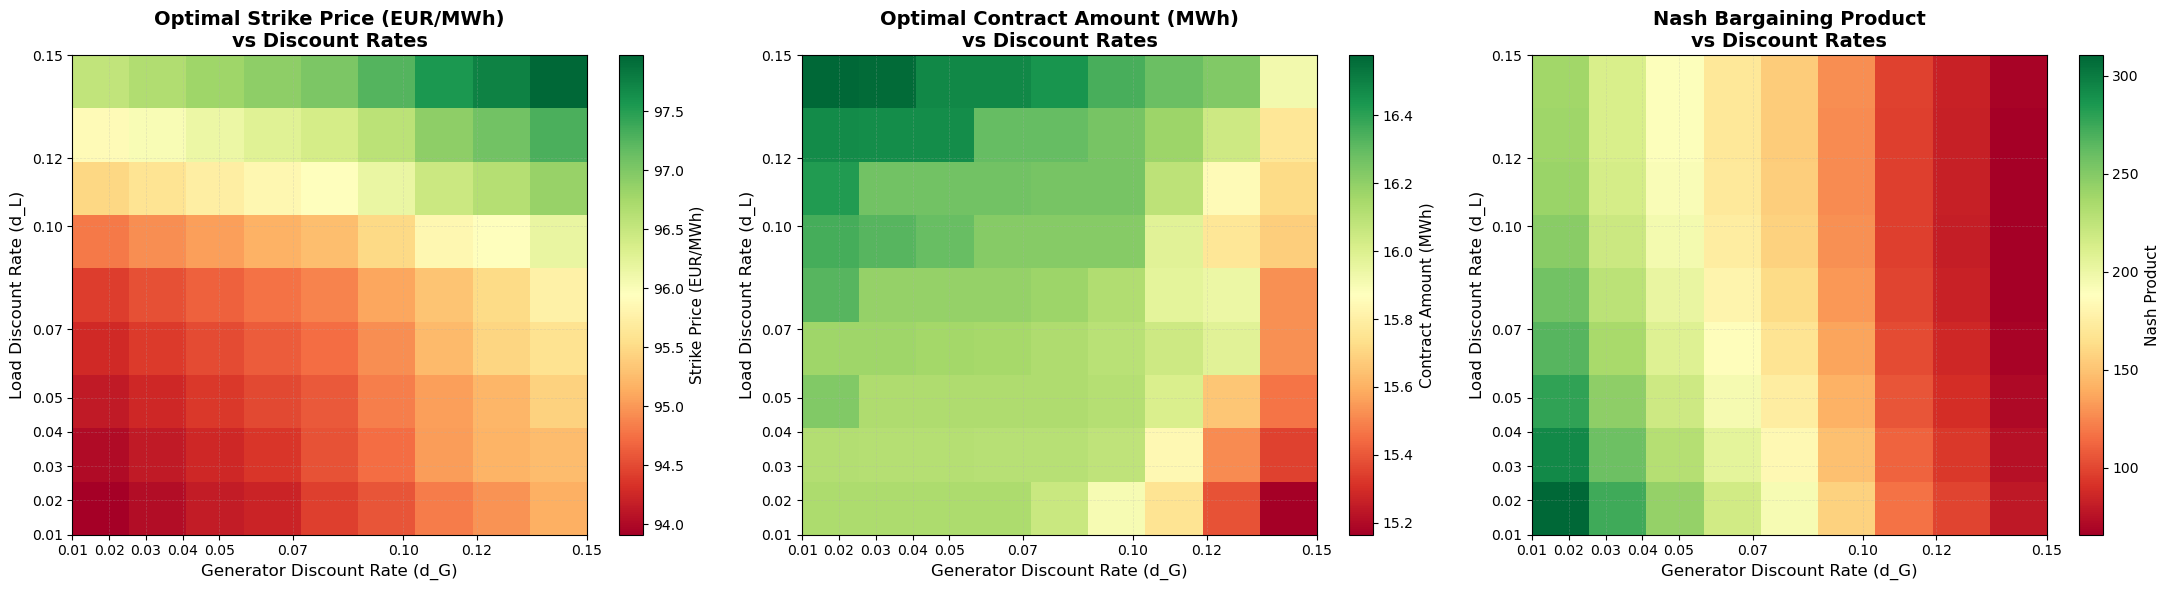


HEATMAP INSIGHTS
Strike Price Range (feasible): [93.91, 97.97] EUR/MWh
Contract Amount Range (feasible): [15.17, 16.58] MWh
Nash Product Range (feasible): [65.9479, 310.3689]


In [19]:
# 2D Heatmap Visualizations
# Create pivot tables for heatmaps (use MWh for contract amount)
pivot_S = df_sensitivity.pivot(index='d_L', columns='d_G', values='S_optimal')
pivot_M = df_sensitivity.pivot(index='d_L', columns='d_G', values='M_optimal_MWh')  # Use MWh instead of GWh/year
pivot_Nash = df_sensitivity.pivot(index='d_L', columns='d_G', values='Nash_Product')
pivot_feasible = df_sensitivity.pivot(index='d_L', columns='d_G', values='Feasible')

# Create figure with 3 heatmaps
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# 1. Optimal Strike Price Heatmap
im1 = ax1.imshow(pivot_S, cmap='RdYlGn', aspect='auto', origin='lower', 
                  extent=[discount_rates_G.min(), discount_rates_G.max(), 
                         discount_rates_L.min(), discount_rates_L.max()])
ax1.set_xlabel('Generator Discount Rate (d_G)', fontsize=12)
ax1.set_ylabel('Load Discount Rate (d_L)', fontsize=12)
ax1.set_title('Optimal Strike Price (EUR/MWh)\nvs Discount Rates', fontsize=14, fontweight='bold')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Strike Price (EUR/MWh)', fontsize=11)

# Mark infeasible regions with hatching
for i, d_L in enumerate(discount_rates_L):
    for j, d_G in enumerate(discount_rates_G):
        if not pivot_feasible.iloc[i, j]:
            # Add red X for infeasible points
            ax1.plot([d_G], [d_L], 'rx', markersize=10, markeredgewidth=2)

# Add grid lines at discount rate values
ax1.set_xticks(discount_rates_G)
ax1.set_yticks(discount_rates_L)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# 2. Optimal Contract Amount Heatmap (MWh)
im2 = ax2.imshow(pivot_M, cmap='RdYlGn', aspect='auto', origin='lower',
                  extent=[discount_rates_G.min(), discount_rates_G.max(), 
                         discount_rates_L.min(), discount_rates_L.max()])
ax2.set_xlabel('Generator Discount Rate (d_G)', fontsize=12)
ax2.set_ylabel('Load Discount Rate (d_L)', fontsize=12)
ax2.set_title('Optimal Contract Amount (MWh)\nvs Discount Rates', fontsize=14, fontweight='bold')

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Contract Amount (MWh)', fontsize=11)

# Mark infeasible regions
for i, d_L in enumerate(discount_rates_L):
    for j, d_G in enumerate(discount_rates_G):
        if not pivot_feasible.iloc[i, j]:
            ax2.plot([d_G], [d_L], 'rx', markersize=10, markeredgewidth=2)

ax2.set_xticks(discount_rates_G)
ax2.set_yticks(discount_rates_L)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# 3. Nash Product Heatmap
im3 = ax3.imshow(pivot_Nash, cmap='RdYlGn', aspect='auto', origin='lower',
                  extent=[discount_rates_G.min(), discount_rates_G.max(), 
                         discount_rates_L.min(), discount_rates_L.max()])
ax3.set_xlabel('Generator Discount Rate (d_G)', fontsize=12)
ax3.set_ylabel('Load Discount Rate (d_L)', fontsize=12)
ax3.set_title('Nash Bargaining Product\nvs Discount Rates', fontsize=14, fontweight='bold')

# Add colorbar
cbar3 = plt.colorbar(im3, ax=ax3)
cbar3.set_label('Nash Product', fontsize=11)

# Mark infeasible regions
for i, d_L in enumerate(discount_rates_L):
    for j, d_G in enumerate(discount_rates_G):
        if not pivot_feasible.iloc[i, j]:
            ax3.plot([d_G], [d_L], 'rx', markersize=10, markeredgewidth=2)

ax3.set_xticks(discount_rates_G)
ax3.set_yticks(discount_rates_L)
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print insights (updated for MWh)
print("\n" + "=" * 80)
print("HEATMAP INSIGHTS")
print("=" * 80)
print(f"Strike Price Range (feasible): [{pivot_S.min().min():.2f}, {pivot_S.max().max():.2f}] EUR/MWh")
print(f"Contract Amount Range (feasible): [{pivot_M.min().min():.2f}, {pivot_M.max().max():.2f}] MWh")
print(f"Nash Product Range (feasible): [{pivot_Nash.min().min():.4f}, {pivot_Nash.max().max():.4f}]")
print("=" * 80)

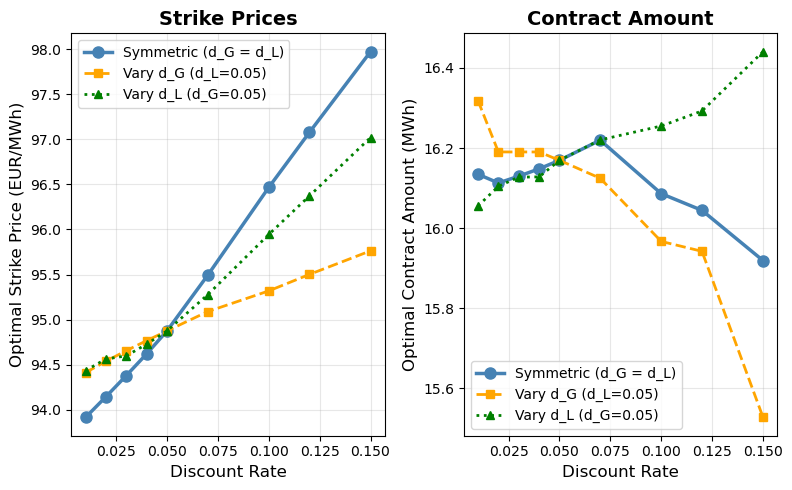


UNIVARIATE SENSITIVITY INSIGHTS

Symmetric Case (d_G = d_L):
  Strike Price range: 93.91 - 97.97 EUR/MWh
  Contract Amount range: 15.92 - 16.22 MWh
  Nash Product range: 68.1970 - 310.3689


In [20]:
# Univariate Sensitivity Curves
# Extract diagonal (symmetric case: d_G = d_L) and cross-sections

# Diagonal case (d_G = d_L)
df_diagonal = df_sensitivity[df_sensitivity['d_G'] == df_sensitivity['d_L']].copy()

# Cross-section: Fix d_L at median, vary d_G
median_d_L = np.median(discount_rates_L)
df_vary_dG = df_sensitivity[df_sensitivity['d_L'] == median_d_L].copy()

# Cross-section: Fix d_G at median, vary d_L
median_d_G = np.median(discount_rates_G)
df_vary_dL = df_sensitivity[df_sensitivity['d_G'] == median_d_G].copy()

# Create 2x2 subplot layout
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 5))

# 1. Strike Price vs Discount Rates
# Diagonal case
ax1.plot(df_diagonal['d_G'], df_diagonal['S_optimal'], 'o-', linewidth=2.5, 
         markersize=8, color='steelblue', label='Symmetric (d_G = d_L)')
# Vary d_G, fix d_L
ax1.plot(df_vary_dG['d_G'], df_vary_dG['S_optimal'], 's--', linewidth=2, 
         markersize=6, color='orange', label=f'Vary d_G (d_L={median_d_L:.2f})')
# Vary d_L, fix d_G
ax1.plot(df_vary_dL['d_L'], df_vary_dL['S_optimal'], '^:', linewidth=2, 
         markersize=6, color='green', label=f'Vary d_L (d_G={median_d_G:.2f})')

ax1.set_xlabel('Discount Rate', fontsize=12)
ax1.set_ylabel('Optimal Strike Price (EUR/MWh)', fontsize=12)
ax1.set_title('Strike Prices', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Contract Amount vs Discount Rates (use MWh)
ax2.plot(df_diagonal['d_G'], df_diagonal['M_optimal_MWh'], 'o-', linewidth=2.5, 
         markersize=8, color='steelblue', label='Symmetric (d_G = d_L)')
ax2.plot(df_vary_dG['d_G'], df_vary_dG['M_optimal_MWh'], 's--', linewidth=2, 
         markersize=6, color='orange', label=f'Vary d_G (d_L={median_d_L:.2f})')
ax2.plot(df_vary_dL['d_L'], df_vary_dL['M_optimal_MWh'], '^:', linewidth=2, 
         markersize=6, color='green', label=f'Vary d_L (d_G={median_d_G:.2f})')

ax2.set_xlabel('Discount Rate', fontsize=12)
ax2.set_ylabel('Optimal Contract Amount (MWh)', fontsize=12)
ax2.set_title('Contract Amount', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights (updated for MWh)
print("\n" + "=" * 80)
print("UNIVARIATE SENSITIVITY INSIGHTS")
print("=" * 80)
print("\nSymmetric Case (d_G = d_L):")
print(f"  Strike Price range: {df_diagonal['S_optimal'].min():.2f} - {df_diagonal['S_optimal'].max():.2f} EUR/MWh")
print(f"  Contract Amount range: {df_diagonal['M_optimal_MWh'].min():.2f} - {df_diagonal['M_optimal_MWh'].max():.2f} MWh")
print(f"  Nash Product range: {df_diagonal['Nash_Product'].min():.4f} - {df_diagonal['Nash_Product'].max():.4f}")
print("=" * 80)

# Sampled Risk Aversion

This section analyzes how varying the load's risk aversion parameter (A_L) affects the optimal contract terms while keeping the generator's risk aversion fixed at A_G = 0.5. We sample A_L uniformly across [0, 1] to understand the full range of risk preferences and their impact on negotiations.

In [21]:
# Sampled Risk Aversion Analysis
# Fix A_G = 0.5, sample A_L uniformly from [0, 1]

# Configuration
A_G_fixed = 0.5
num_samples = 100  # Number of A_L samples to test
np.random.seed(42)  # For reproducibility

# Sample A_L uniformly from [0, 1]
A_L_samples = np.linspace(0, 1, num_samples)

# Fixed contract parameters (not indexed by scenarios)
Scenarios_S_risk = False
Scenarios_M_risk = False

# Initialize results storage
results_risk_list_AL = []

print(f"Starting Sampled Risk Aversion Analysis...")
print(f"Total samples: {num_samples}")
print(f"A_G (fixed): {A_G_fixed}")
print(f"A_L range: [0.0, 1.0]\n")

# Loop over A_L samples
for idx, A_L_sample in enumerate(A_L_samples):
    try:
        # Create contract data with sampled A_L
        contract_data_risk_AL = ContractData(
            scenario_path=scenario_path,
            time_horizon=time_horizon,
            num_scenarios=num_scenarios,
            discount_rate_G=discount_rate_G,
            discount_rate_L=discount_rate_L,
            alpha=0.95,
            strikeprice_min=40 * 1e-3,
            strikeprice_max=130 * 1e-3,
            contract_amount_min=0,
            contract_amount_max=generator_contract_capacity * 8760 * 1e-3,
            A_G=A_G_fixed,
            A_L=A_L_sample,
            tau_G=0.5,
            tau_L=0.5,
            Scenarios_S=Scenarios_S_risk,
            Scenarios_M=Scenarios_M_risk
        )
        
        # Run Nash bargaining optimization
        model_risk = NashBargaining(contract_data_risk_AL)
        model_risk.run()
        
        # Store results
        results_risk_list_AL.append({
            'A_G': A_G_fixed,
            'A_L': A_L_sample,
            'S_optimal': model_risk.results.avg_strike_price,  # EUR/MWh
            'SR_star' : model_risk.data.SR_star_new,
            'SU_star': model_risk.data.SU_star_new,
            'M_optimal': model_risk.results.avg_contract_amount,  # GWh/year
            'M_optimal_MWh': model_risk.results.avg_contract_amount_hour,  # MWh
            'U_G': model_risk.results.utility_G,
            'U_L': model_risk.results.utility_L,
            'Zeta_G': contract_data_risk_AL.Zeta_G,
            'Zeta_L': contract_data_risk_AL.Zeta_L,
            'Nash_Product': model_risk.results.Nash_Product_model,
            'CVaR_G': model_risk.results.CVaRG,
            'CVaR_L': model_risk.results.CVaRL,
            'Earnings_G': model_risk.results.avg_earnings_G,
            'Earnings_L': model_risk.results.avg_earnings_L,
            'Feasible': True,
            'Status': 'OPTIMAL'
        })
        
        # Clean up
        del model_risk, contract_data_risk_AL
        
    except Exception as e:
        # Store infeasible case
        results_risk_list_AL.append({
            'A_G': A_G_fixed,
            'A_L': A_L_sample,
            'S_optimal': np.nan,
            'SR_star':np.nan,
            'SU_star': np.nan,
            'M_optimal': np.nan,
            'M_optimal_MWh': np.nan,
            'U_G': np.nan,
            'U_L': np.nan,
            'Zeta_G': np.nan,
            'Zeta_L': np.nan,
            'Nash_Product': np.nan,
            'CVaR_G': np.nan,
            'CVaR_L': np.nan,
            'Earnings_G': np.nan,
            'Earnings_L': np.nan,
            'Feasible': False,
            'Status': 'INFEASIBLE'
        })
        print(f"  Sample {idx+1}/{num_samples}: A_L={A_L_sample:.3f} - INFEASIBLE ({str(e)[:50]})")
    
    # Progress update every 20 samples
    if (idx + 1) % 20 == 0:
        print(f"  Completed {idx+1}/{num_samples} samples...")

# Create DataFrame
df_risk_aversion_AL = pd.DataFrame(results_risk_list_AL)

print(f"\n✓ Sampled Risk Aversion Analysis Complete!")
print(f"  Total samples: {len(df_risk_aversion_AL)}")
print(f"  Feasible: {df_risk_aversion_AL['Feasible'].sum()}")
print(f"  Infeasible: {(~df_risk_aversion_AL['Feasible']).sum()}")

# Summary statistics
df_risk_feasible_AL = df_risk_aversion_AL[df_risk_aversion_AL['Feasible']].copy()
if len(df_risk_feasible_AL) > 0:
    print(f"\n--- Summary Statistics (Feasible Cases) ---")
    print(f"Strike Price (S):")
    print(f"  Mean: {df_risk_feasible_AL['S_optimal'].mean():.2f} EUR/MWh")
    print(f"  Std: {df_risk_feasible_AL['S_optimal'].std():.2f} EUR/MWh")
    print(f"  Range: [{df_risk_feasible_AL['S_optimal'].min():.2f}, {df_risk_feasible_AL['S_optimal'].max():.2f}]")
    print(f"\nContract Amount (M):")
    print(f"  Mean: {df_risk_feasible_AL['M_optimal_MWh'].mean():.1f} MWh")
    print(f"  Std: {df_risk_feasible_AL['M_optimal_MWh'].std():.1f} MWh")
    print(f"  Range: [{df_risk_feasible_AL['M_optimal_MWh'].min():.1f}, {df_risk_feasible_AL['M_optimal_MWh'].max():.1f}]")

df_risk_aversion_AL.head()

Starting Sampled Risk Aversion Analysis...
Total samples: 100
A_G (fixed): 0.5
A_L range: [0.0, 1.0]

Initial Threshold at M=0 SR* [EUR/MWh]: 76305.025
Initial Threshold at M=0 SU* [EUR/MWh]: 85506.901
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 1.01110
Avg Strike Price (EUR/MWh): 81.97273
Lower Strike Price SR* (EUR/MWh): 76.30503
Upper Strike Price SU* (EUR/MWh): 85.50690
Avg Contract Amount (GWh/year): 52.84606
Avg Contract Amount (MWh): 6.03266
Avg Earnings G: 71.04504
Avg Earnings L: -178.77817
CVaR G: 65.42719
CVaR L: -233.00000
Utility G: 68.23612
Utility L: -178.77817
Threat Point G: 65.37414
Threat Point L: -181.41792
Nash Product: 7.55492
Initial Threshold at M=0 SR* [EUR/MWh]: 76305.025
Initial Threshold at M=0 SU* [EUR/MWh]: 85697.590
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  

,A_G,A_L,S_optimal,SR_star,SU_star,M_optimal,M_optimal_MWh,U_G,U_L,Zeta_G,Zeta_L,Nash_Product,CVaR_G,CVaR_L,Earnings_G,Earnings_L,Feasible,Status
0,0.5,0.000000,81.972729,76.305025,85.506901,52.846058,6.032655,68.236117,-178.778171,65.374136,-181.417924,7.554923,65.427194,-233.000000,71.045040,-178.778171,True,OPTIMAL
1,0.5,0.010101,82.108953,76.305025,85.697590,53.460491,6.102796,68.313358,-179.119325,65.374136,-181.830322,7.968221,65.501403,-205.473022,71.125312,-178.850410,True,OPTIMAL
2,0.5,0.020202,82.219205,76.305025,85.888280,53.685869,6.128524,68.391264,-179.459866,65.374136,-182.242721,8.396228,65.577535,-205.486020,71.204994,-178.923244,True,OPTIMAL
3,0.5,0.030303,82.317156,76.305025,86.078970,53.702626,6.130437,68.470894,-179.801607,65.374136,-182.655119,8.836636,65.656980,-205.555011,71.284809,-178.996813,True,OPTIMAL
4,0.5,0.040404,82.410264,76.305025,86.269660,53.702629,6.130437,68.547513,-180.140547,65.374136,-183.067517,9.288379,65.733595,-205.625755,71.361431,-179.067485,True,OPTIMAL


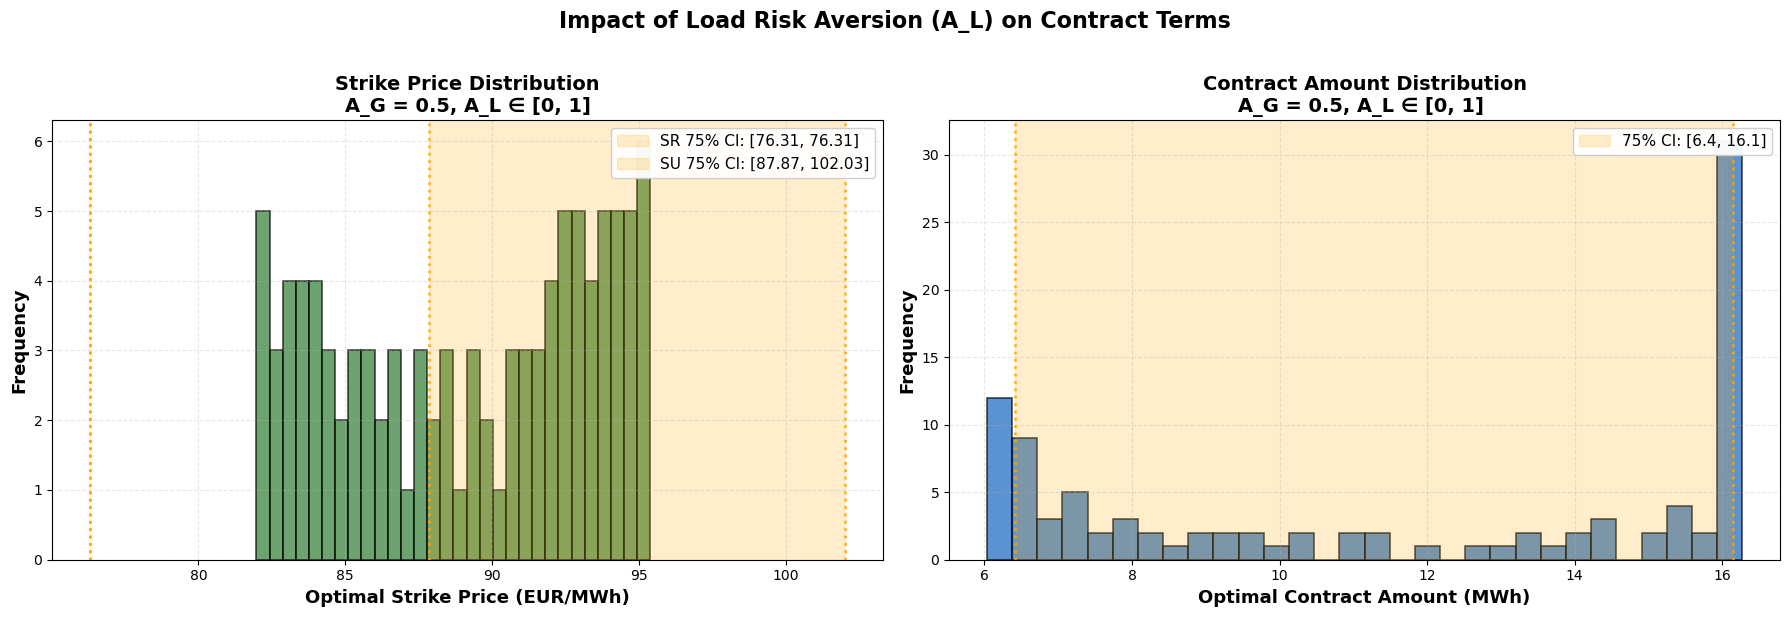


DISTRIBUTION STATISTICS

Strike Price (EUR/MWh):
  Mean:        89.22
  Median:      89.83
  Std Dev:     4.34
  85% CI:      [83.40, 94.29]
  Range:       [81.97, 95.39]
\SR Price (EUR/MWh):
  75% CI:      [76.31, 76.31]
\SU Price (EUR/MWh):
  75% CI:      [87.87, 102.03]

Contract Amount (MWh):
  Mean:        11.6
  Median:      11.7
  Std Dev:     4.1
  75% CI:      [6.4, 16.1]
  Range:       [6.0, 16.3]


In [22]:
# Distribution Plots with 85% Confidence Intervals
# Show distributions of strike price and contract amount with confidence intervals

# Filter only feasible results
df_risk_plot_AL = df_risk_feasible_AL[df_risk_feasible_AL['Feasible']].copy()

if len(df_risk_plot_AL) > 0:
    # Calculate 75% confidence intervals (10th and 90th percentiles)
    ci_lower = 12.5  # Lower bound: 25th percentile
    ci_upper = 87.5  # Upper bound: 75th percentile
    
    # Calculate statistics for strike price
    S_mean_AL = df_risk_plot_AL['S_optimal'].mean()
    S_median_AL = df_risk_plot_AL['S_optimal'].median()
    S_ci_low_AL = np.percentile(df_risk_plot_AL['S_optimal'], ci_lower)
    S_ci_high_AL = np.percentile(df_risk_plot_AL['S_optimal'], ci_upper)
    
    # Calculate statistics for contract amount
    M_mean_AL = df_risk_plot_AL['M_optimal_MWh'].mean()
    M_median_AL = df_risk_plot_AL['M_optimal_MWh'].median()
    M_ci_low_AL = np.percentile(df_risk_plot_AL['M_optimal_MWh'], ci_lower)
    M_ci_high_AL = np.percentile(df_risk_plot_AL['M_optimal_MWh'], ci_upper)

    #SU star (Given that A_L is being varied so upper level)

    SU_star_mean_AL = df_risk_plot_AL['SU_star'].mean()
    SU_median_AL = df_risk_plot_AL['SU_star'].median()
    SU_ci_low_AL = np.percentile(df_risk_plot_AL['SU_star'], ci_lower)
    SU_ci_high_AL = np.percentile(df_risk_plot_AL['SU_star'], ci_upper)

    SR_star_mean_AL = df_risk_plot_AL['SR_star'].mean()
    SR_median_AL = df_risk_plot_AL['SR_star'].median()
    SR_ci_low_AL = np.percentile(df_risk_plot_AL['SR_star'], ci_lower)
    SR_ci_high_AL = np.percentile(df_risk_plot_AL['SR_star'], ci_upper)



    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Strike Price Distribution
    ax1.hist(df_risk_plot_AL['S_optimal'], bins=30, alpha=0.7, color='#2E7D32', 
             edgecolor='black', linewidth=1.2, density=False)
    
    # Add 85% confidence interval shading
    #ax1.axvspan(S_ci_low_AL, S_ci_high_AL, alpha=0.2, color='orange', 
    #            label=f'85% CI: [{S_ci_low_AL:.2f}, {S_ci_high_AL:.2f}]')
    #ax1.axvline(S_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    #ax1.axvline(S_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    #ax1.axvline(SR_star, color='blue', linestyle='--', linewidth=2.5, 
    #        label=f'Lower Strike Price SR*: {SR_star:.2f} EUR/MWh')

    ax1.axvspan(SR_ci_low_AL, SR_ci_high_AL, alpha=0.2, color='orange', 
                label=f'SR 75% CI: [{SR_ci_low_AL:.2f}, {SR_ci_high_AL:.2f}]')
    ax1.axvline(SR_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax1.axvline(SR_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    
    
    ax1.axvspan(SU_ci_low_AL, SU_ci_high_AL, alpha=0.2, color='orange', 
                label=f'SU 75% CI: [{SU_ci_low_AL:.2f}, {SU_ci_high_AL:.2f}]')
    ax1.axvline(SU_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax1.axvline(SU_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('Optimal Strike Price (EUR/MWh)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    ax1.set_title(f'Strike Price Distribution\nA_G = {A_G_fixed}, A_L ∈ [0, 1]', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper right', framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 2: Contract Amount Distribution
    ax2.hist(df_risk_plot_AL['M_optimal_MWh'], bins=30, alpha=0.7, color='#1565C0', 
             edgecolor='black', linewidth=1.2, density=False)
    
    # Add 90% confidence interval shading
    ax2.axvspan(M_ci_low_AL, M_ci_high_AL, alpha=0.2, color='orange', 
                label=f'75% CI: [{M_ci_low_AL:.1f}, {M_ci_high_AL:.1f}]')
    ax2.axvline(M_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax2.axvline(M_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    
    ax2.set_xlabel('Optimal Contract Amount (MWh)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    ax2.set_title(f'Contract Amount Distribution\nA_G = {A_G_fixed}, A_L ∈ [0, 1] ', 
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11, loc='upper right', framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.suptitle('Impact of Load Risk Aversion (A_L) on Contract Terms', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DISTRIBUTION STATISTICS")
    print("="*60)
    print(f"\nStrike Price (EUR/MWh):")
    print(f"  Mean:        {S_mean_AL:.2f}")
    print(f"  Median:      {S_median_AL:.2f}")
    print(f"  Std Dev:     {df_risk_plot_AL['S_optimal'].std():.2f}")
    print(f"  85% CI:      [{S_ci_low_AL:.2f}, {S_ci_high_AL:.2f}]")
    print(f"  Range:       [{df_risk_plot_AL['S_optimal'].min():.2f}, {df_risk_plot_AL['S_optimal'].max():.2f}]")

    print(f"\SR Price (EUR/MWh):")
    print(f"  75% CI:      [{SR_ci_low_AL:.2f}, {SR_ci_high_AL:.2f}]")
    print(f"\SU Price (EUR/MWh):")
    print(f"  75% CI:      [{SU_ci_low_AL:.2f}, {SU_ci_high_AL:.2f}]")
  
    
    print(f"\nContract Amount (MWh):")
    print(f"  Mean:        {M_mean_AL:.1f}")
    print(f"  Median:      {M_median_AL:.1f}")
    print(f"  Std Dev:     {df_risk_plot_AL['M_optimal_MWh'].std():.1f}")
    print(f"  75% CI:      [{M_ci_low_AL:.1f}, {M_ci_high_AL:.1f}]")
    print(f"  Range:       [{df_risk_plot_AL['M_optimal_MWh'].min():.1f}, {df_risk_plot_AL['M_optimal_MWh'].max():.1f}]")
    print("="*60)
    
else:
    print("No feasible solutions to plot!")

In [23]:
# Sampled Risk Aversion Analysis
# Fix A_G = 0.5, sample A_L uniformly from [0, 1]
""" 
# Configuration
A_L_fixed = 0.5
num_samples = 100  # Number of A_L samples to test
np.random.seed(42)  # For reproducibility

# Sample A_L uniformly from [0, 1]
A_G_samples = np.linspace(0, 1, num_samples)

# Fixed contract parameters (not indexed by scenarios)
Scenarios_S_risk = False
Scenarios_M_risk = False

# Initialize results storage
results_risk_list_AG = []

print(f"Starting Sampled Risk Aversion Analysis...")
print(f"Total samples: {num_samples}")
print(f"A_L (fixed): {A_L_fixed}")
print(f"A_G range: [0.0, 1.0]\n")

# Loop over A_G samples
for idx, A_G_sample in enumerate(A_G_samples):
    try:
        # Create contract data with sampled A_G
        contract_data_risk_AG = ContractData(
            scenario_path=scenario_path,
            time_horizon=time_horizon,
            num_scenarios=num_scenarios,
            discount_rate_G=discount_rate_G,
            discount_rate_L=discount_rate_L,
            alpha=0.95,
            strikeprice_min=40 * 1e-3,
            strikeprice_max=130 * 1e-3,
            contract_amount_min=0,
            contract_amount_max=generator_contract_capacity * 8760 * 1e-3,
            A_G=A_G_sample,
            A_L=A_L_fixed,
            tau_G=0.5,
            tau_L=0.5,
            Scenarios_S=Scenarios_S_risk,
            Scenarios_M=Scenarios_M_risk
        )
        
        # Run Nash bargaining optimization
        model_risk = NashBargaining(contract_data_risk_AG)
        model_risk.run()
        
        # Store results
        results_risk_list_AG.append({
            'A_G': A_G_sample,
            'A_L': A_L_fixed,
            'S_optimal': model_risk.results.avg_strike_price,  # EUR/MWh
            'SR_star':  model_risk.data.SR_star_new,
            'SU_star':  model_risk.data.SU_star_new,
            'M_optimal': model_risk.results.avg_contract_amount,  # GWh/year
            'M_optimal_MWh': model_risk.results.avg_contract_amount_hour,  # MWh
            'U_G': model_risk.results.utility_G,
            'U_L': model_risk.results.utility_L,
            'Zeta_G': contract_data_risk_AG.Zeta_G,
            'Zeta_L': contract_data_risk_AG.Zeta_L,
            'Nash_Product': model_risk.results.Nash_Product_model,
            'CVaR_G': model_risk.results.CVaRG,
            'CVaR_L': model_risk.results.CVaRL,
            'Earnings_G': model_risk.results.avg_earnings_G,
            'Earnings_L': model_risk.results.avg_earnings_L,
            'Feasible': True,
            'Status': 'OPTIMAL'
        })
        
        # Clean up
        del model_risk, contract_data_risk_AG
        
    except Exception as e:
        # Store infeasible case
        results_risk_list_AG.append({
            'A_G': A_G_samples,
            'A_L': A_L_fixed,
            'S_optimal': np.nan,
            'SR_star':np.nan,
            'SU_star': np.nan,
            'M_optimal': np.nan,
            'M_optimal_MWh': np.nan,
            'U_G': np.nan,
            'U_L': np.nan,
            'Zeta_G': np.nan,
            'Zeta_L': np.nan,
            'Nash_Product': np.nan,
            'CVaR_G': np.nan,
            'CVaR_L': np.nan,
            'Earnings_G': np.nan,
            'Earnings_L': np.nan,
            'Feasible': False,
            'Status': 'INFEASIBLE'
        })
        print(f"  Sample {idx+1}/{num_samples}: A_L={A_L_sample:.3f} - INFEASIBLE ({str(e)[:50]})")
    
    # Progress update every 20 samples
    if (idx + 1) % 20 == 0:
        print(f"  Completed {idx+1}/{num_samples} samples...")

# Create DataFrame
df_risk_aversion_AG = pd.DataFrame(results_risk_list_AG)

print(f"\n✓ Sampled Risk Aversion Analysis Complete!")
print(f"  Total samples: {len(df_risk_aversion_AG)}")
print(f"  Feasible: {df_risk_aversion_AG['Feasible'].sum()}")
print(f"  Infeasible: {(~df_risk_aversion_AG['Feasible']).sum()}")

# Summary statistics
df_risk_feasible_AG = df_risk_aversion_AG[df_risk_aversion_AG['Feasible']].copy()
if len(df_risk_feasible_AG) > 0:
    print(f"\n--- Summary Statistics (Feasible Cases) ---")
    print(f"Strike Price (S):")
    print(f"  Mean: {df_risk_feasible_AG['S_optimal'].mean():.2f} EUR/MWh")
    print(f"  Std: {df_risk_feasible_AG['S_optimal'].std():.2f} EUR/MWh")
    print(f"  Range: [{df_risk_feasible_AG['S_optimal'].min():.2f}, {df_risk_feasible_AG['S_optimal'].max():.2f}]")
    print(f"\nContract Amount (M):")
    print(f"  Mean: {df_risk_feasible_AG['M_optimal_MWh'].mean():.1f} MWh")
    print(f"  Std: {df_risk_feasible_AG['M_optimal_MWh'].std():.1f} MWh")
    print(f"  Range: [{df_risk_feasible_AG['M_optimal_MWh'].min():.1f}, {df_risk_feasible_AG['M_optimal_MWh'].max():.1f}]")

df_risk_aversion_AG.head()
"""

' \n# Configuration\nA_L_fixed = 0.5\nnum_samples = 100  # Number of A_L samples to test\nnp.random.seed(42)  # For reproducibility\n\n# Sample A_L uniformly from [0, 1]\nA_G_samples = np.linspace(0, 1, num_samples)\n\n# Fixed contract parameters (not indexed by scenarios)\nScenarios_S_risk = False\nScenarios_M_risk = False\n\n# Initialize results storage\nresults_risk_list_AG = []\n\nprint(f"Starting Sampled Risk Aversion Analysis...")\nprint(f"Total samples: {num_samples}")\nprint(f"A_L (fixed): {A_L_fixed}")\nprint(f"A_G range: [0.0, 1.0]\n")\n\n# Loop over A_G samples\nfor idx, A_G_sample in enumerate(A_G_samples):\n    try:\n        # Create contract data with sampled A_G\n        contract_data_risk_AG = ContractData(\n            scenario_path=scenario_path,\n            time_horizon=time_horizon,\n            num_scenarios=num_scenarios,\n            discount_rate_G=discount_rate_G,\n            discount_rate_L=discount_rate_L,\n            alpha=0.95,\n            strikeprice_m

In [24]:
# Distribution Plots with 85% Confidence Intervals
# Show distributions of strike price and contract amount with confidence intervals
"""
# Filter only feasible results
df_risk_plot_AG = df_risk_aversion_AG[df_risk_aversion_AG['Feasible']].copy()

if len(df_risk_plot_AG) > 0:
    # Calculate 85% confidence intervals (10th and 90th percentiles)
    ci_lower = 25  # Lower bound: 10th percentile
    ci_upper = 75  # Upper bound: 90th percentile
    
    # Calculate statistics for strike price
    S_mean_AG = df_risk_plot_AG['S_optimal'].mean()
    S_median_AG = df_risk_plot_AG['S_optimal'].median()
    S_ci_low_AG = np.percentile(df_risk_plot_AG['S_optimal'], ci_lower)
    S_ci_high_AG = np.percentile(df_risk_plot_AG['S_optimal'], ci_upper)

    SR_star_mean_AG = df_risk_plot_AG['SR_star'].mean()
    SR_median_AG = df_risk_plot_AG['SR_star'].median()
    SR_ci_low_AG = np.percentile(df_risk_plot_AG['SR_star'], ci_lower)
    SR_ci_high_AG = np.percentile(df_risk_plot_AG['SR_star'], ci_upper)

    SU_star_mean_AG = df_risk_plot_AG['SU_star'].mean()
    SU_median_AG = df_risk_plot_AG['SU_star'].median()
    SU_ci_low_AG = np.percentile(df_risk_plot_AG['SU_star'], ci_lower)
    SU_ci_high_AG = np.percentile(df_risk_plot_AG['SU_star'], ci_upper)
    
    
    # Calculate statistics for contract amount
    M_mean_AG = df_risk_plot_AG['M_optimal_MWh'].mean()
    M_median_AG = df_risk_plot_AG['M_optimal_MWh'].median()
    M_ci_low_AG = np.percentile(df_risk_plot_AG['M_optimal_MWh'], ci_lower)
    M_ci_high_AG = np.percentile(df_risk_plot_AG['M_optimal_MWh'], ci_upper)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Strike Price Distribution
    ax1.hist(df_risk_plot_AG['S_optimal'], bins=30, alpha=0.7, color='#2E7D32', 
             edgecolor='black', linewidth=1.2, density=False)
    
    # Add 85% confidence interval shading
    ax1.axvspan(S_ci_low_AG, S_ci_high_AG, alpha=0.2, color='orange', 
                label=f'S* 75% CI: [{S_ci_low_AG:.2f}, {S_ci_high_AG:.2f}]')
    ax1.axvline(S_ci_low_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax1.axvline(S_ci_high_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    
    
    ax1.axvspan(SR_ci_low_AG, SR_ci_high_AG, alpha=0.2, color='orange', 
                label=f'SR 75% CI: [{SR_ci_low_AG:.2f}, {SR_ci_high_AG:.2f}]')
    ax1.axvline(SR_ci_low_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax1.axvline(SR_ci_high_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)

    ax1.axvspan(SU_ci_low_AG, SU_ci_high_AG, alpha=0.2, color='orange', 
                label=f'SU 75% CI: [{SU_ci_low_AG:.2f}, {SU_ci_high_AG:.2f}]')
    ax1.axvline(SU_ci_low_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax1.axvline(SU_ci_high_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('Optimal Strike Price (EUR/MWh)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    ax1.set_title(f'Strike Price Distribution\nA_G = {A_G_fixed}, A_L ∈ [0, 1] (n={len(df_risk_plot_AG)})', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper right', framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 2: Contract Amount Distribution
    ax2.hist(df_risk_plot_AG['M_optimal_MWh'], bins=30, alpha=0.7, color='#1565C0', 
             edgecolor='black', linewidth=1.2, density=False)
    
    
    # Add 90% confidence interval shading
    ax2.axvspan(M_ci_low_AG, M_ci_high_AG, alpha=0.2, color='orange', 
                label=f'75% CI: [{M_ci_low_AG:.1f}, {M_ci_high_AG:.1f}]')
    ax2.axvline(M_ci_low_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax2.axvline(M_ci_high_AG, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    
    ax2.set_xlabel('Optimal Contract Amount (MWh)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    ax2.set_title(f'Contract Amount Distribution\nA_G = {A_G_fixed}, A_L ∈ [0, 1] (n={len(df_risk_plot_AG)})', 
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11, loc='upper right', framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.suptitle('Impact of Load Risk Aversion (A_L) on Contract Terms\nDistributions with 75% Confidence Intervals', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DISTRIBUTION STATISTICS")
    print("="*60)
    print(f"\nStrike Price (EUR/MWh):")
    print(f"  Mean:        {S_mean_AG:.2f}")
    print(f"  Median:      {S_median_AG:.2f}")
    print(f"  Std Dev:     {df_risk_plot_AG['S_optimal'].std():.2f}")
    print(f"  85% CI:      [{S_ci_low_AG:.2f}, {S_ci_high_AG:.2f}]")
    print(f"  Range:       [{df_risk_plot_AG['S_optimal'].min():.2f}, {df_risk_plot_AG['S_optimal'].max():.2f}]")

    print(f"\SR Price (EUR/MWh):")
    print(f"  75% CI:      [{SR_ci_low_AG:.2f}, {SR_ci_high_AG:.2f}]")
    print(f"\SU Price (EUR/MWh):")
    print(f"  75% CI:      [{SU_ci_low_AG:.2f}, {SU_ci_high_AG:.2f}]")
    
    print(f"\nContract Amount (MWh):")
    print(f"  Mean:        {M_mean_AG:.1f}")
    print(f"  Median:      {M_median_AG:.1f}")
    print(f"  Std Dev:     {df_risk_plot_AG['M_optimal_MWh'].std():.1f}")
    print(f"  75% CI:      [{M_ci_low_AG:.1f}, {M_ci_high_AG:.1f}]")
    print(f"  Range:       [{df_risk_plot_AG['M_optimal_MWh'].min():.1f}, {df_risk_plot_AG['M_optimal_MWh'].max():.1f}]")
    print("="*60)
    
else:
    print("No feasible solutions to plot!")
"""

'\n# Filter only feasible results\ndf_risk_plot_AG = df_risk_aversion_AG[df_risk_aversion_AG[\'Feasible\']].copy()\n\nif len(df_risk_plot_AG) > 0:\n    # Calculate 85% confidence intervals (10th and 90th percentiles)\n    ci_lower = 25  # Lower bound: 10th percentile\n    ci_upper = 75  # Upper bound: 90th percentile\n    \n    # Calculate statistics for strike price\n    S_mean_AG = df_risk_plot_AG[\'S_optimal\'].mean()\n    S_median_AG = df_risk_plot_AG[\'S_optimal\'].median()\n    S_ci_low_AG = np.percentile(df_risk_plot_AG[\'S_optimal\'], ci_lower)\n    S_ci_high_AG = np.percentile(df_risk_plot_AG[\'S_optimal\'], ci_upper)\n\n    SR_star_mean_AG = df_risk_plot_AG[\'SR_star\'].mean()\n    SR_median_AG = df_risk_plot_AG[\'SR_star\'].median()\n    SR_ci_low_AG = np.percentile(df_risk_plot_AG[\'SR_star\'], ci_lower)\n    SR_ci_high_AG = np.percentile(df_risk_plot_AG[\'SR_star\'], ci_upper)\n\n    SU_star_mean_AG = df_risk_plot_AG[\'SU_star\'].mean()\n    SU_median_AG = df_risk_plot_AG[

In [25]:
# Configuration
A_G_fixed_samples = [0.1,0.5,0.9]
num_samples = 100  # Number of A_L samples to test
np.random.seed(42)  # For reproducibility

dict_A_G_fixed = {}

# Sample A_L uniformly from [0, 1]
A_L_samples = np.linspace(0, 1, num_samples)

# Fixed contract parameters (not indexed by scenarios)
Scenarios_S_risk = False
Scenarios_M_risk = False

# Initialize results storage

print(f"Starting Sampled Risk Aversion Analysis...")
print(f"Total samples: {num_samples}")
print(f"A_G (fixed): {A_G_fixed_samples}")
print(f"A_L range: [0.0, 1.0]\n")

# Loop over A_L samples
for idy, A_G_fixed in enumerate(A_G_fixed_samples):
    results_risk_list_AL = []

    for idx, A_L_sample in enumerate(A_L_samples):
        try:
            # Create contract data with sampled A_L
            contract_data_risk_AL = ContractData(
                scenario_path=scenario_path,
                time_horizon=time_horizon,
                num_scenarios=num_scenarios,
                discount_rate_G=discount_rate_G,
                discount_rate_L=discount_rate_L,
                alpha=0.95,
                strikeprice_min=40 * 1e-3,
                strikeprice_max=130 * 1e-3,
                contract_amount_min=0,
                contract_amount_max=generator_contract_capacity * 8760 * 1e-3,
                A_G=A_G_fixed,
                A_L=A_L_sample,
                tau_G=0.5,
                tau_L=0.5,
                Scenarios_S=Scenarios_S_risk,
                Scenarios_M=Scenarios_M_risk
            )
            
            # Run Nash bargaining optimization
            model_risk = NashBargaining(contract_data_risk_AL)
            model_risk.run()
            
            # Store results
            results_risk_list_AL.append({
                'A_G': A_G_fixed,
                'A_L': A_L_sample,
                'S_optimal': model_risk.results.avg_strike_price,  # EUR/MWh
                'SR_star' : model_risk.data.SR_star_new,
                'SU_star': model_risk.data.SU_star_new,
                'M_optimal': model_risk.results.avg_contract_amount,  # GWh/year
                'M_optimal_MWh': model_risk.results.avg_contract_amount_hour,  # MWh
                'U_G': model_risk.results.utility_G,
                'U_L': model_risk.results.utility_L,
                'Zeta_G': contract_data_risk_AL.Zeta_G,
                'Zeta_L': contract_data_risk_AL.Zeta_L,
                'Nash_Product': model_risk.results.Nash_Product_model,
                'CVaR_G': model_risk.results.CVaRG,
                'CVaR_L': model_risk.results.CVaRL,
                'Earnings_G': model_risk.results.avg_earnings_G,
                'Earnings_L': model_risk.results.avg_earnings_L,
                'Feasible': True,
                'Status': 'OPTIMAL'
            })
            
            # Clean up
            del model_risk, contract_data_risk_AL
            
        except Exception as e:
            # Store infeasible case
            results_risk_list_AL.append({
                'A_G': A_G_fixed,
                'A_L': A_L_sample,
                'S_optimal': np.nan,
                'SR_star':np.nan,
                'SU_star': np.nan,
                'M_optimal': np.nan,
                'M_optimal_MWh': np.nan,
                'U_G': np.nan,
                'U_L': np.nan,
                'Zeta_G': np.nan,
                'Zeta_L': np.nan,
                'Nash_Product': np.nan,
                'CVaR_G': np.nan,
                'CVaR_L': np.nan,
                'Earnings_G': np.nan,
                'Earnings_L': np.nan,
                'Feasible': False,
                'Status': 'INFEASIBLE'
            })
            print(f"  Sample {idx+1}/{num_samples}: A_L={A_L_sample:.3f} - INFEASIBLE ({str(e)[:50]})")
        
        # Progress update every 20 samples
        if (idx + 1) % 20 == 0:
            print(f"  Completed {idx+1}/{num_samples} samples...")

    # Create DataFrame
    df_risk_aversion_AL = pd.DataFrame(results_risk_list_AL)

    #Save to Dict 
    dict_A_G_fixed[A_G_fixed] = df_risk_aversion_AL


    print(f"\n✓ Sampled Risk Aversion Analysis Complete!")
    print(f"  Total samples: {len(df_risk_aversion_AL)}")
    print(f"  Feasible: {df_risk_aversion_AL['Feasible'].sum()}")
    print(f"  Infeasible: {(~df_risk_aversion_AL['Feasible']).sum()}")

    # Summary statistics
    df_risk_feasible_AL = df_risk_aversion_AL[df_risk_aversion_AL['Feasible']].copy()
    if len(df_risk_feasible_AL) > 0:
        print(f"\n--- Summary Statistics (Feasible Cases) ---")
        print(f"Strike Price (S):")
        print(f"  Mean: {df_risk_feasible_AL['S_optimal'].mean():.2f} EUR/MWh")
        print(f"  Std: {df_risk_feasible_AL['S_optimal'].std():.2f} EUR/MWh")
        print(f"  Range: [{df_risk_feasible_AL['S_optimal'].min():.2f}, {df_risk_feasible_AL['S_optimal'].max():.2f}]")
        print(f"\nContract Amount (M):")
        print(f"  Mean: {df_risk_feasible_AL['M_optimal_MWh'].mean():.1f} MWh")
        print(f"  Std: {df_risk_feasible_AL['M_optimal_MWh'].std():.1f} MWh")
        print(f"  Range: [{df_risk_feasible_AL['M_optimal_MWh'].min():.1f}, {df_risk_feasible_AL['M_optimal_MWh'].max():.1f}]")

Starting Sampled Risk Aversion Analysis...
Total samples: 100
A_G (fixed): [0.1, 0.5, 0.9]
A_L range: [0.0, 1.0]

Initial Threshold at M=0 SR* [EUR/MWh]: 83500.703
Initial Threshold at M=0 SU* [EUR/MWh]: 85506.901
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
  Sample 1/100: A_L=0.000 - INFEASIBLE (Optimization of Nash Bargaining Model was not succ)
Initial Threshold at M=0 SR* [EUR/MWh]: 83500.703
Initial Threshold at M=0 SU* [EUR/MWh]: 85697.590
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
  Sample 2/100: A_L=0.010 - INFEASIBLE (Optimization of Nash Bargaining Model was not succ)
Initial Threshold at M=0 SR* [EUR/MWh]: 83500.703
Initial Threshold at M=0 SU* [EUR/MWh]: 85888.280
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06
  Sample 3/100: A_L=0.020 - INFEASIBLE (Optimization of Nash Bargaining Model was not succ)
Initial Threshold at M=0 SR* [EUR/MWh]: 83500.703
Initial Threshold at M=


Processing A_G = 0.1


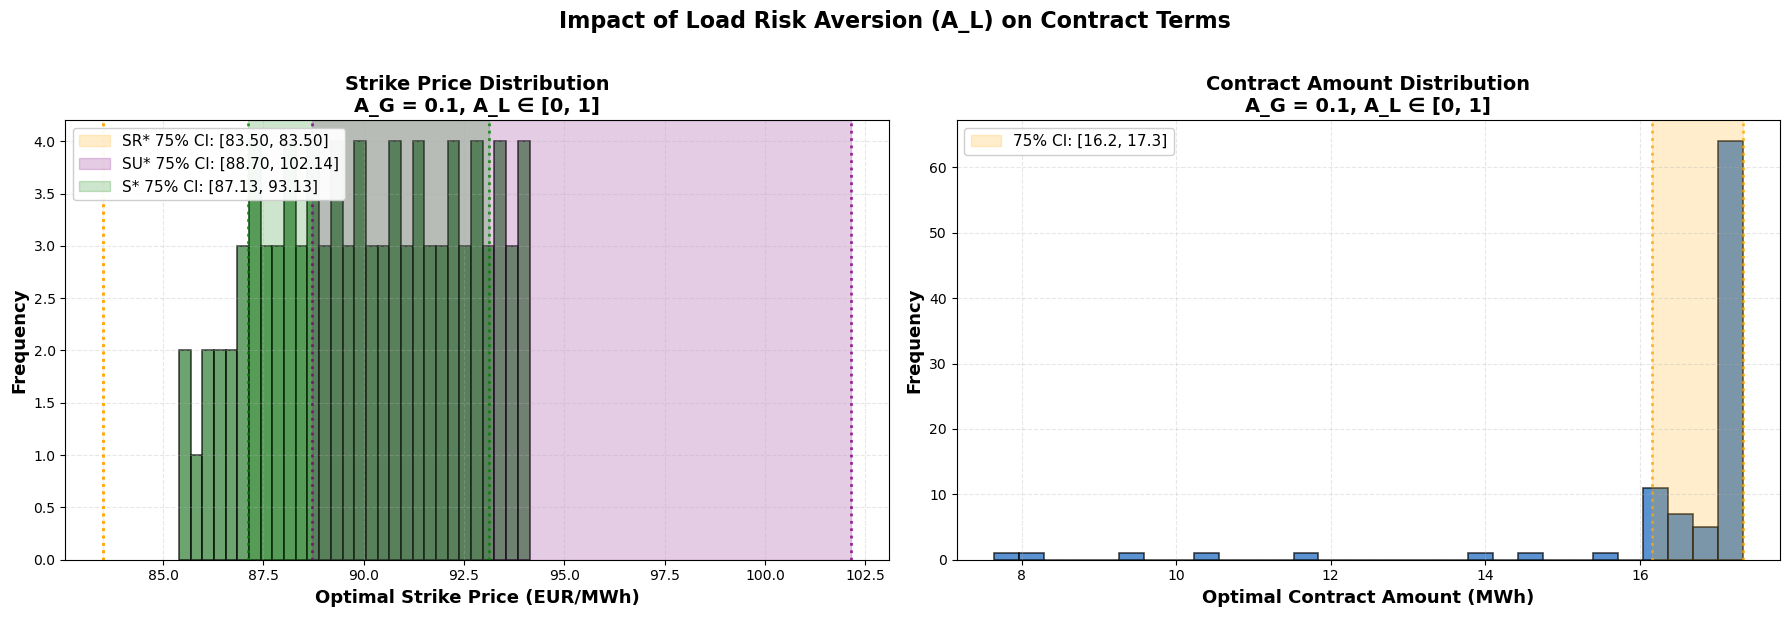


DISTRIBUTION STATISTICS

Strike Price (EUR/MWh):
  Mean:        90.11
  Median:      90.13
  Std Dev:     2.39
  85% CI:      [87.13, 93.13]
  Range:       [85.40, 94.13]
\SR Price (EUR/MWh):
  75% CI:      [83.50, 83.50]
\SU Price (EUR/MWh):
  75% CI:      [88.70, 102.14]

Contract Amount (MWh):
  Mean:        16.6
  Median:      17.3
  Std Dev:     1.8
  75% CI:      [16.2, 17.3]
  Range:       [7.6, 17.3]

Processing A_G = 0.5


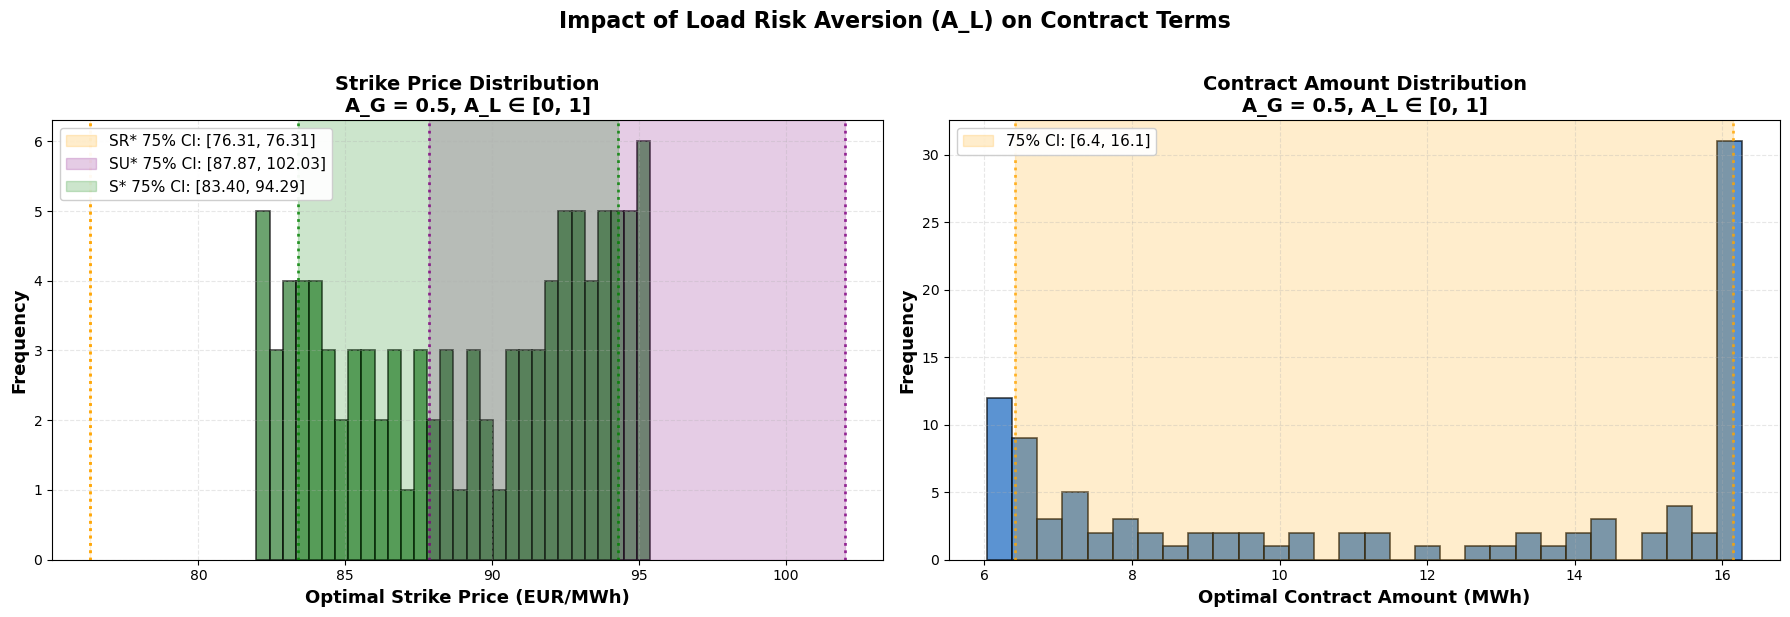


DISTRIBUTION STATISTICS

Strike Price (EUR/MWh):
  Mean:        89.22
  Median:      89.83
  Std Dev:     4.34
  85% CI:      [83.40, 94.29]
  Range:       [81.97, 95.39]
\SR Price (EUR/MWh):
  75% CI:      [76.31, 76.31]
\SU Price (EUR/MWh):
  75% CI:      [87.87, 102.03]

Contract Amount (MWh):
  Mean:        11.6
  Median:      11.7
  Std Dev:     4.1
  75% CI:      [6.4, 16.1]
  Range:       [6.0, 16.3]

Processing A_G = 0.9


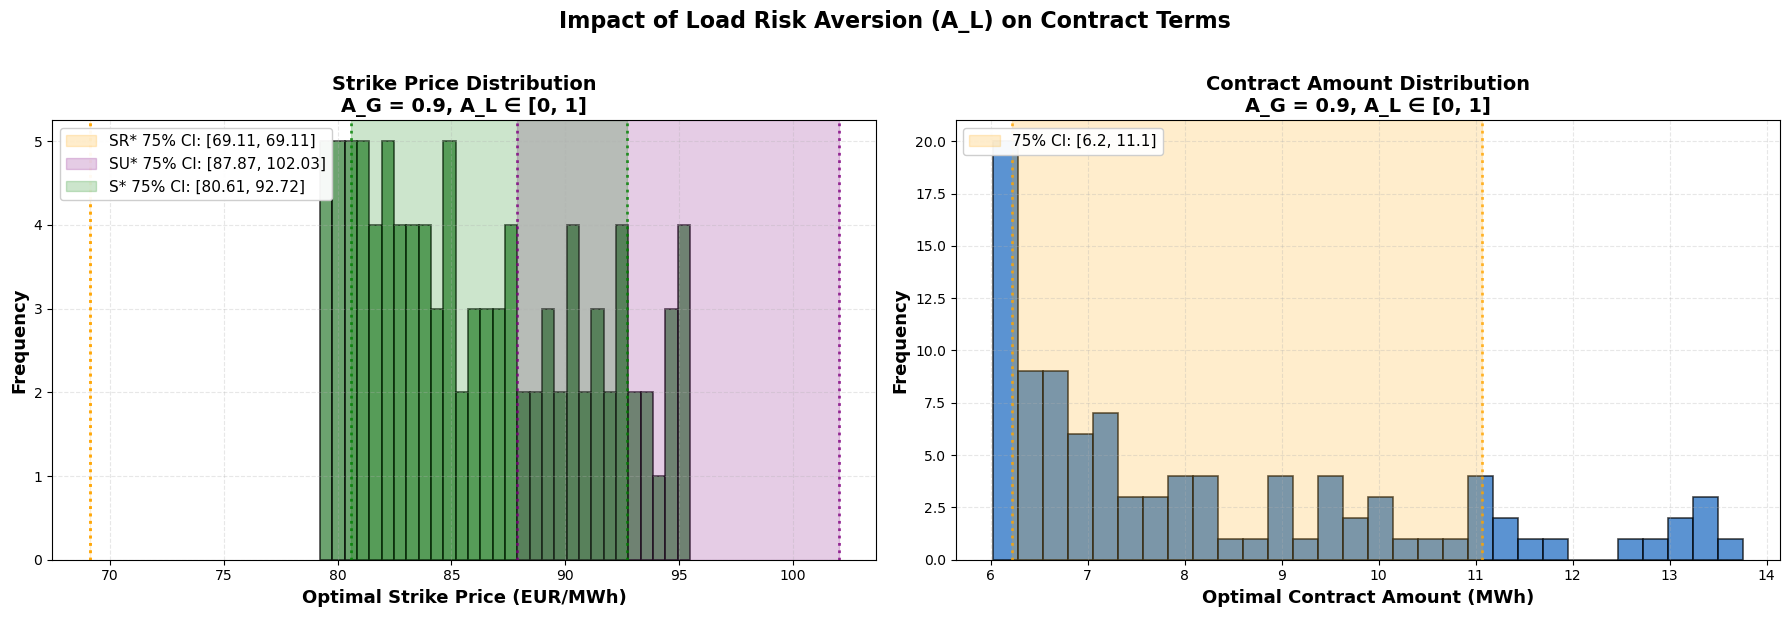


DISTRIBUTION STATISTICS

Strike Price (EUR/MWh):
  Mean:        86.26
  Median:      85.44
  Std Dev:     4.84
  85% CI:      [80.61, 92.72]
  Range:       [79.23, 95.49]
\SR Price (EUR/MWh):
  75% CI:      [69.11, 69.11]
\SU Price (EUR/MWh):
  75% CI:      [87.87, 102.03]

Contract Amount (MWh):
  Mean:        8.2
  Median:      7.2
  Std Dev:     2.2
  75% CI:      [6.2, 11.1]
  Range:       [6.0, 13.8]


In [36]:

for idx, AG_fixed in enumerate(A_G_fixed_samples):
    print(f"\nProcessing A_G = {AG_fixed}")
    
    # Get the dataframe for this A_G value
    df_risk_plot_AL = dict_A_G_fixed[AG_fixed]
    
    # Filter for feasible solutions only
    df_risk_plot_AL = df_risk_plot_AL[df_risk_plot_AL['Feasible']].copy()


    if len(df_risk_plot_AL) > 0:
        # Calculate 75% confidence intervals (10th and 90th percentiles)
        ci_lower = 12.5  # Lower bound: 25th percentile
        ci_upper = 87.5  # Upper bound: 75th percentile
        
        # Calculate statistics for strike price
        S_mean_AL = df_risk_plot_AL['S_optimal'].mean()
        S_median_AL = df_risk_plot_AL['S_optimal'].median()
        S_ci_low_AL = np.percentile(df_risk_plot_AL['S_optimal'], ci_lower)
        S_ci_high_AL = np.percentile(df_risk_plot_AL['S_optimal'], ci_upper)
        
        # Calculate statistics for contract amount
        M_mean_AL = df_risk_plot_AL['M_optimal_MWh'].mean()
        M_median_AL = df_risk_plot_AL['M_optimal_MWh'].median()
        M_ci_low_AL = np.percentile(df_risk_plot_AL['M_optimal_MWh'], ci_lower)
        M_ci_high_AL = np.percentile(df_risk_plot_AL['M_optimal_MWh'], ci_upper)

        #SU star (Given that A_L is being varied so upper level)

        SU_star_mean_AL = df_risk_plot_AL['SU_star'].mean()
        SU_median_AL = df_risk_plot_AL['SU_star'].median()
        SU_ci_low_AL = np.percentile(df_risk_plot_AL['SU_star'], ci_lower)
        SU_ci_high_AL = np.percentile(df_risk_plot_AL['SU_star'], ci_upper)

        SR_star_mean_AL = df_risk_plot_AL['SR_star'].mean()
        SR_median_AL = df_risk_plot_AL['SR_star'].median()
        SR_ci_low_AL = np.percentile(df_risk_plot_AL['SR_star'], ci_lower)
        SR_ci_high_AL = np.percentile(df_risk_plot_AL['SR_star'], ci_upper)



        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        
        # Plot 1: Strike Price Distribution
        ax1.hist(df_risk_plot_AL['S_optimal'], bins=30, alpha=0.7, color='#2E7D32', 
                edgecolor='black', linewidth=1.2, density=False)
        
        # Add 85% confidence interval shading
        #ax1.axvspan(S_ci_low_AL, S_ci_high_AL, alpha=0.2, color='orange', 
        #            label=f'85% CI: [{S_ci_low_AL:.2f}, {S_ci_high_AL:.2f}]')
        #ax1.axvline(S_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
        #ax1.axvline(S_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
        #ax1.axvline(SR_star, color='blue', linestyle='--', linewidth=2.5, 
        #        label=f'Lower Strike Price SR*: {SR_star:.2f} EUR/MWh')

        ax1.axvspan(SR_ci_low_AL, SR_ci_high_AL, alpha=0.2, color='orange', 
                    label=f'SR* 75% CI: [{SR_ci_low_AL:.2f}, {SR_ci_high_AL:.2f}]')
        ax1.axvline(SR_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
        ax1.axvline(SR_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
        
        
        ax1.axvspan(SU_ci_low_AL, SU_ci_high_AL, alpha=0.2, color='purple', 
                    label=f'SU* 75% CI: [{SU_ci_low_AL:.2f}, {SU_ci_high_AL:.2f}]')
        ax1.axvline(SU_ci_low_AL, color='purple', linestyle=':', linewidth=2, alpha=0.8)
        ax1.axvline(SU_ci_high_AL, color='purple', linestyle=':', linewidth=2, alpha=0.8)


        ax1.axvspan(S_ci_low_AL, S_ci_high_AL, alpha=0.2, color='green', 
                    label=f'S* 75% CI: [{S_ci_low_AL:.2f}, {S_ci_high_AL:.2f}]')
        ax1.axvline(S_ci_low_AL, color='green', linestyle=':', linewidth=2, alpha=0.8)
        ax1.axvline(S_ci_high_AL, color='green', linestyle=':', linewidth=2, alpha=0.8)
        
        ax1.set_xlabel('Optimal Strike Price (EUR/MWh)', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
        ax1.set_title(f'Strike Price Distribution\nA_G = {AG_fixed}, A_L ∈ [0, 1]', 
                    fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11, loc='upper left', framealpha=0.95)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Plot 2: Contract Amount Distribution
        ax2.hist(df_risk_plot_AL['M_optimal_MWh'], bins=30, alpha=0.7, color='#1565C0', 
                edgecolor='black', linewidth=1.2, density=False)
        
        # Add 90% confidence interval shading
        ax2.axvspan(M_ci_low_AL, M_ci_high_AL, alpha=0.2, color='orange', 
                    label=f'75% CI: [{M_ci_low_AL:.1f}, {M_ci_high_AL:.1f}]')
        ax2.axvline(M_ci_low_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
        ax2.axvline(M_ci_high_AL, color='orange', linestyle=':', linewidth=2, alpha=0.8)
        
        ax2.set_xlabel('Optimal Contract Amount (MWh)', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
        ax2.set_title(f'Contract Amount Distribution\nA_G = {AG_fixed}, A_L ∈ [0, 1]', 
                    fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11, loc='upper left', framealpha=0.95)
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        plt.suptitle('Impact of Load Risk Aversion (A_L) on Contract Terms', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
       
        
        # Print detailed statistics
        print("\n" + "="*60)
        print("DISTRIBUTION STATISTICS")
        print("="*60)
        print(f"\nStrike Price (EUR/MWh):")
        print(f"  Mean:        {S_mean_AL:.2f}")
        print(f"  Median:      {S_median_AL:.2f}")
        print(f"  Std Dev:     {df_risk_plot_AL['S_optimal'].std():.2f}")
        print(f"  85% CI:      [{S_ci_low_AL:.2f}, {S_ci_high_AL:.2f}]")
        print(f"  Range:       [{df_risk_plot_AL['S_optimal'].min():.2f}, {df_risk_plot_AL['S_optimal'].max():.2f}]")

        print(f"\SR Price (EUR/MWh):")
        print(f"  75% CI:      [{SR_ci_low_AL:.2f}, {SR_ci_high_AL:.2f}]")
        print(f"\SU Price (EUR/MWh):")
        print(f"  75% CI:      [{SU_ci_low_AL:.2f}, {SU_ci_high_AL:.2f}]")
    
        
        print(f"\nContract Amount (MWh):")
        print(f"  Mean:        {M_mean_AL:.1f}")
        print(f"  Median:      {M_median_AL:.1f}")
        print(f"  Std Dev:     {df_risk_plot_AL['M_optimal_MWh'].std():.1f}")
        print(f"  75% CI:      [{M_ci_low_AL:.1f}, {M_ci_high_AL:.1f}]")
        print(f"  Range:       [{df_risk_plot_AL['M_optimal_MWh'].min():.1f}, {df_risk_plot_AL['M_optimal_MWh'].max():.1f}]")
        print("="*60)
        
    else:
        print("No feasible solutions to plot!")

In [27]:
dict_A_G_fixed[0.1]

,A_G,A_L,S_optimal,SR_star,SU_star,M_optimal,M_optimal_MWh,U_G,U_L,Zeta_G,Zeta_L,Nash_Product,CVaR_G,CVaR_L,Earnings_G,Earnings_L,Feasible,Status
0,0.1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,INFEASIBLE
1,0.1,0.010101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,INFEASIBLE
2,0.1,0.020202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,INFEASIBLE
3,0.1,0.030303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,INFEASIBLE
4,0.1,0.040404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,INFEASIBLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.1,0.959596,93.789010,83.500703,103.622434,151.805107,17.329350,90.536934,-203.559194,72.066159,-220.595753,314.678427,63.982355,-203.743242,93.487442,-199.188053,True,OPTIMAL
96,0.1,0.969697,93.874391,83.500703,103.813124,151.805109,17.329350,90.735549,-203.788400,72.066159,-221.008151,321.482245,64.180968,-203.926436,93.686058,-199.371246,True,OPTIMAL
97,0.1,0.979798,93.959771,83.500703,104.003814,151.805110,17.329351,90.934164,-204.017605,72.066159,-221.420549,328.358833,64.379581,-204.109629,93.884673,-199.554439,True,OPTIMAL
98,0.1,0.989899,94.045152,83.500703,104.194504,151.805112,17.329351,91.132779,-204.246810,72.066159,-221.832948,335.308190,64.578194,-204.292822,94.083288,-199.737632,True,OPTIMAL


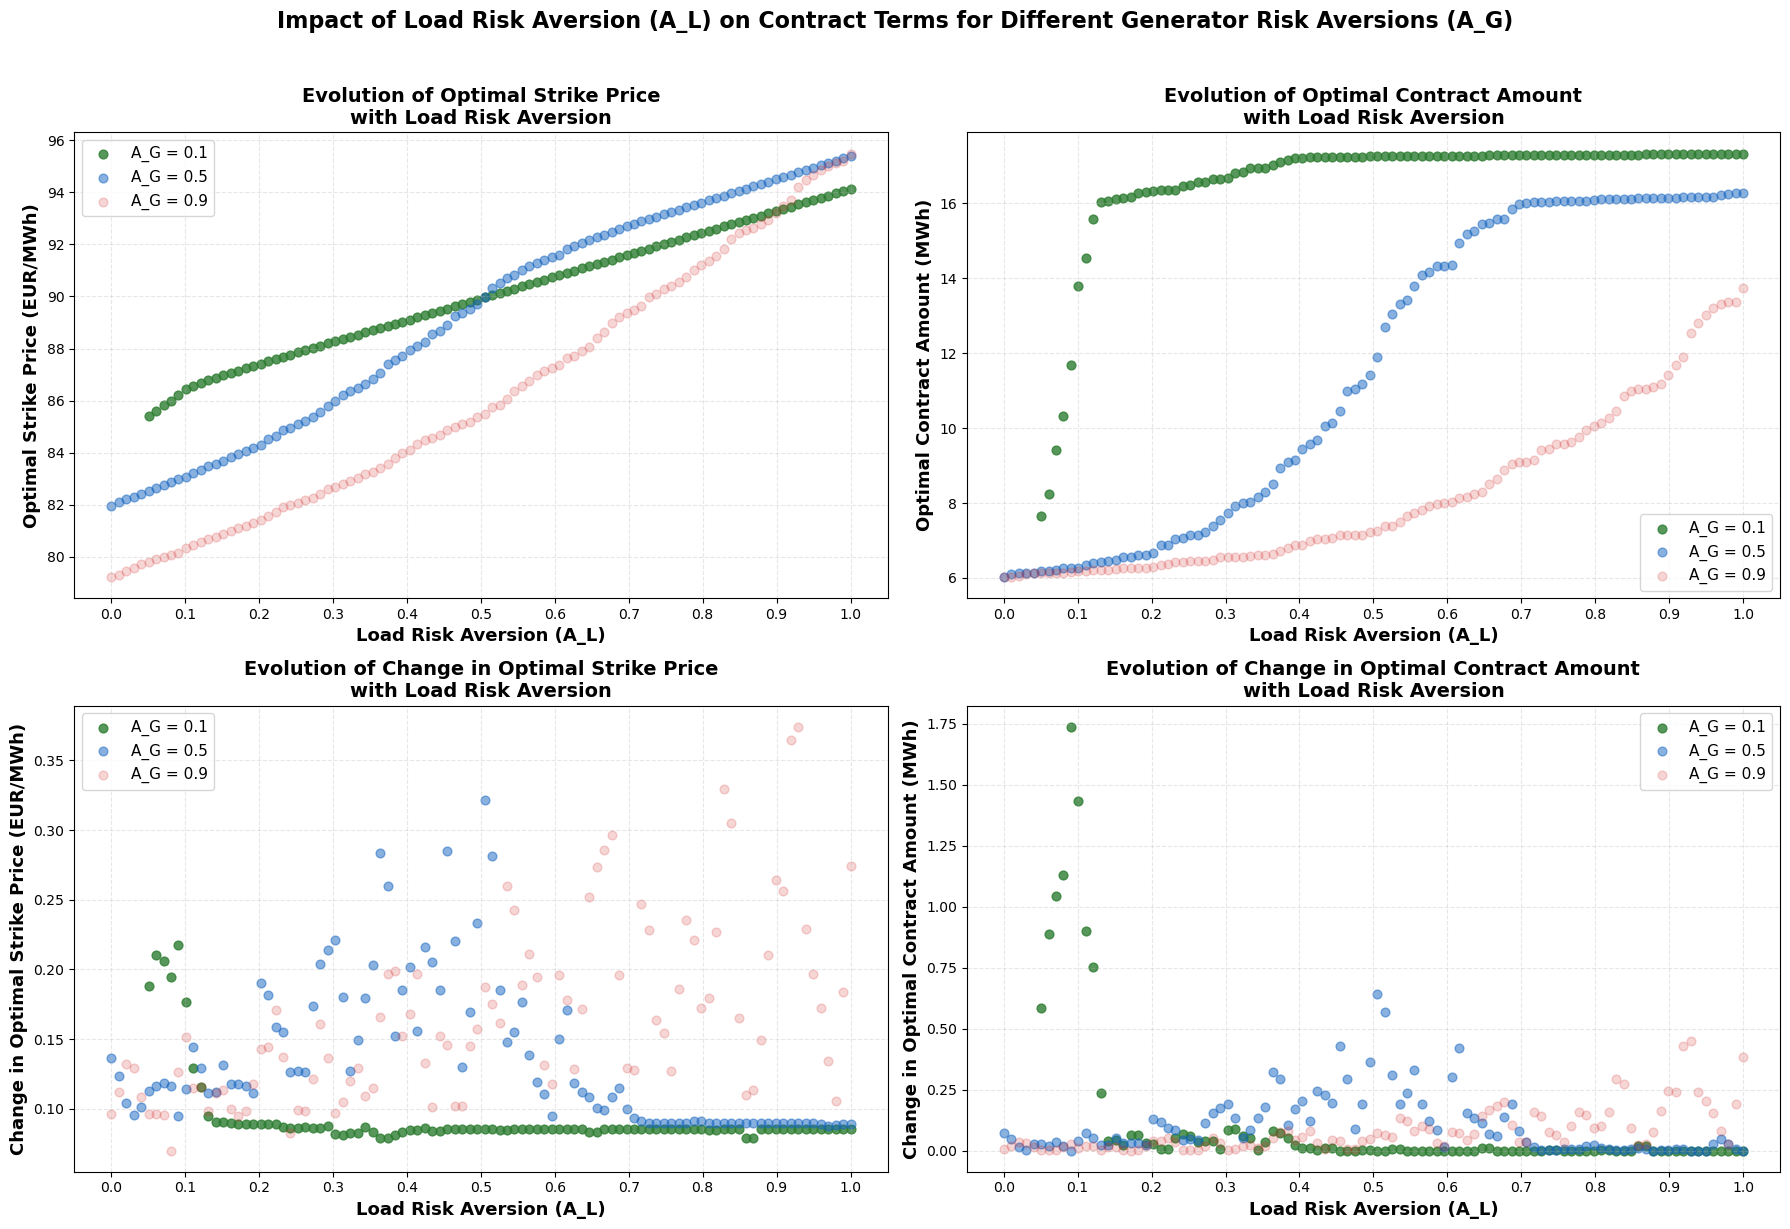


EVOLUTION SUMMARY

A_G = 0.1:
  Feasible solutions: 95/100
  Strike Price range: [85.40, 94.13] EUR/MWh
  Contract Amount range: [7.6, 17.3] MWh
  Strike Price correlation with A_L: 0.999
  Contract Amount correlation with A_L: 0.574
  Strike Price correlation with A_G: nan
  Contract Amount correlation with A_G: nan

A_G = 0.5:
  Feasible solutions: 100/100
  Strike Price range: [81.97, 95.39] EUR/MWh
  Contract Amount range: [6.0, 16.3] MWh
  Strike Price correlation with A_L: 0.992
  Contract Amount correlation with A_L: 0.963
  Strike Price correlation with A_G: nan
  Contract Amount correlation with A_G: nan

A_G = 0.9:
  Feasible solutions: 100/100
  Strike Price range: [79.23, 95.49] EUR/MWh
  Contract Amount range: [6.0, 13.8] MWh
  Strike Price correlation with A_L: 0.993
  Contract Amount correlation with A_L: 0.929
  Strike Price correlation with A_G: nan
  Contract Amount correlation with A_G: nan


In [32]:
plt.clf()
plt.close('all')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Define colors for different A_G values
colors = ['#2E7D32', '#1565C0', '#D32F2F']  # Green, Blue, Red
alphas = [0.8,0.5,0.2]

for idx, AG_fixed in enumerate(A_G_fixed_samples):

    df_risk_plot_AL = dict_A_G_fixed[AG_fixed].copy()
    df_feasible = df_risk_plot_AL[df_risk_plot_AL['Feasible']].copy()
    df_infeasible = df_risk_plot_AL[~df_risk_plot_AL['Feasible']].copy()
    
    # Scatter only (remove line plots)
    if len(df_feasible) > 0:
        ax1.scatter(df_feasible['A_L'], df_feasible['S_optimal'],
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}' )
        
        ax2.scatter(df_feasible['A_L'], df_feasible['M_optimal_MWh'],
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}')


    # Slopes of them 

    ax3.scatter(df_feasible['A_L'], np.gradient(df_feasible['S_optimal'].values),
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}' )
    
    ax4.scatter(df_feasible['A_L'], np.gradient(df_feasible['M_optimal_MWh'].values),
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}')

# Formatting
ax1.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Optimal Strike Price (EUR/MWh)', fontsize=13, fontweight='bold')
ax1.set_title('Evolution of Optimal Strike Price\nwith Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(-0.05, 1.05)
ax1.set_xticks(np.arange(0, 1.01, 0.1))


ax2.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Optimal Contract Amount (MWh)', fontsize=13, fontweight='bold')
ax2.set_title('Evolution of Optimal Contract Amount\nwith Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax2.set_xticks(np.arange(0, 1.01, 0.1))
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(-0.05, 1.05)

ax3.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Change in Optimal Strike Price (EUR/MWh)', fontsize=13, fontweight='bold')
ax3.set_title('Evolution of Change in Optimal Strike Price\nwith Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim(-0.05, 1.05)
ax3.set_xticks(np.arange(0, 1.01, 0.1))

ax4.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Change in Optimal Contract Amount (MWh)', fontsize=13, fontweight='bold')
ax4.set_title('Evolution of Change in Optimal Contract Amount\nwith Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim(-0.05, 1.05)
ax4.set_xticks(np.arange(0, 1.01, 0.1))

plt.suptitle(
    'Impact of Load Risk Aversion (A_L) on Contract Terms '
    'for Different Generator Risk Aversions (A_G)',
    fontsize=16, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("EVOLUTION SUMMARY")
print("="*80)

for idx, AG_fixed in enumerate(A_G_fixed_samples):
    df_risk_plot_AL = dict_A_G_fixed[AG_fixed].copy()
    df_feasible = df_risk_plot_AL[df_risk_plot_AL['Feasible']].copy()
    
    if len(df_feasible) > 0:
        print(f"\nA_G = {AG_fixed}:")
        print(f"  Feasible solutions: {len(df_feasible)}/{len(df_risk_plot_AL)}")
        print(f"  Strike Price range: [{df_feasible['S_optimal'].min():.2f}, {df_feasible['S_optimal'].max():.2f}] EUR/MWh")
        print(f"  Contract Amount range: [{df_feasible['M_optimal_MWh'].min():.1f}, {df_feasible['M_optimal_MWh'].max():.1f}] MWh")
        
        # Check for trends
        if len(df_feasible) > 1:
            s_corr = df_feasible[['A_L', 'S_optimal']].corr().iloc[0, 1]
            m_corr = df_feasible[['A_L', 'M_optimal_MWh']].corr().iloc[0, 1]
            print(f"  Strike Price correlation with A_L: {s_corr:.3f}")
            print(f"  Contract Amount correlation with A_L: {m_corr:.3f}")

            s_corr = df_feasible[['A_G', 'S_optimal']].corr().iloc[0, 1]
            m_corr = df_feasible[['A_G', 'M_optimal_MWh']].corr().iloc[0, 1]
            print(f"  Strike Price correlation with A_G: {s_corr:.3f}")
            print(f"  Contract Amount correlation with A_G: {m_corr:.3f}")


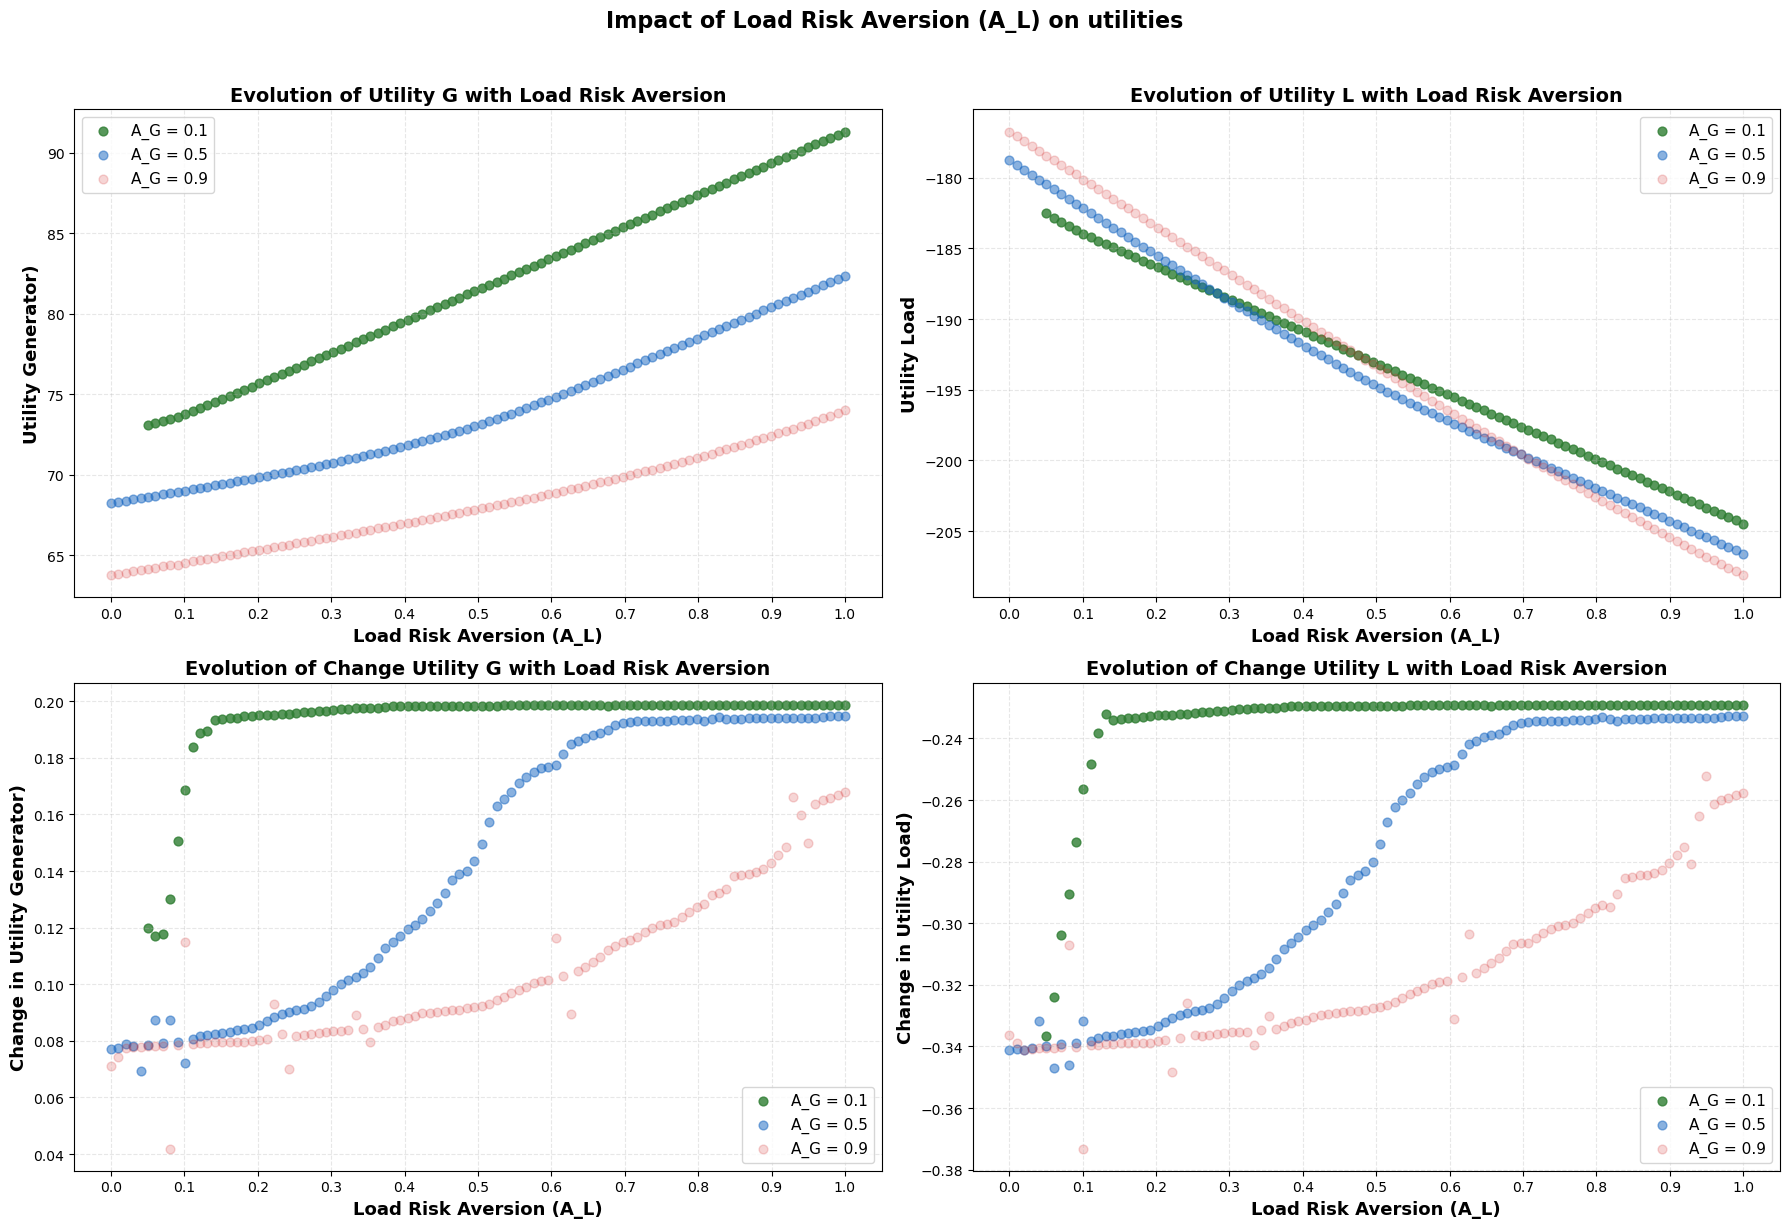

In [29]:
plt.clf()
plt.close('all')
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Define colors for different A_G values
colors = ['#2E7D32', '#1565C0', '#D32F2F']  # Green, Blue, Red
alphas = [0.8,0.5,0.2]

for idx, AG_fixed in enumerate(A_G_fixed_samples):

    df_risk_plot_AL = dict_A_G_fixed[AG_fixed].copy()
    df_feasible = df_risk_plot_AL[df_risk_plot_AL['Feasible']].copy()
    df_infeasible = df_risk_plot_AL[~df_risk_plot_AL['Feasible']].copy()
    
    # Scatter only (remove line plots)
    if len(df_feasible) > 0:
        ax1.scatter(df_feasible['A_L'], df_feasible['U_G'],
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}')
        
   
        ax2.scatter(df_feasible['A_L'], df_feasible['U_L'],
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}' )
        

        ax3.scatter(df_feasible['A_L'], np.gradient(df_feasible['U_G'].values),
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}')
        
   
        ax4.scatter(df_feasible['A_L'], np.gradient(df_feasible['U_L'].values),
                    s=40, alpha=alphas[idx], c=colors[idx],
                    label=f'A_G = {AG_fixed}' )
        
        
# Formatting
ax1.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Utility Generator)', fontsize=13, fontweight='bold')
ax1.set_title('Evolution of Utility G with Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(-0.05, 1.05)
ax1.set_xticks(np.arange(0, 1.01, 0.1))


ax2.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Utility Load', fontsize=13, fontweight='bold')
ax2.set_title('Evolution of Utility L with Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax2.set_xticks(np.arange(0, 1.01, 0.1))
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(-0.05, 1.05)


ax3.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Change in Utility Generator)', fontsize=13, fontweight='bold')
ax3.set_title('Evolution of Change Utility G with Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim(-0.05, 1.05)
ax3.set_xticks(np.arange(0, 1.01, 0.1))

ax4.set_xlabel('Load Risk Aversion (A_L)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Change in Utility Load)', fontsize=13, fontweight='bold')
ax4.set_title('Evolution of Change Utility L with Load Risk Aversion',
              fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim(-0.05, 1.05)
ax4.set_xticks(np.arange(0, 1.01, 0.1))
plt.suptitle(
    'Impact of Load Risk Aversion (A_L) on utilities',
    fontsize=16, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.show()

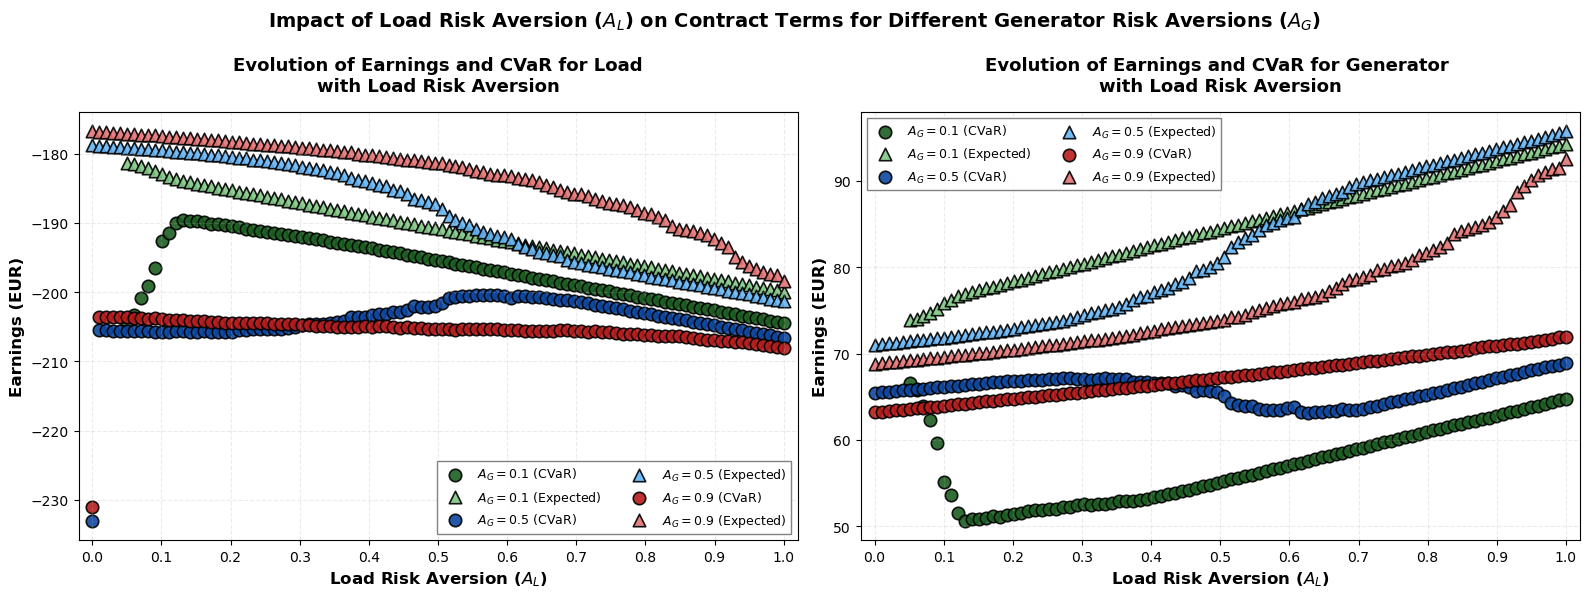

In [30]:
plt.clf()
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for different A_G values
colors_cvar = {'0.1': '#1B5E20', '0.5': '#0D47A1', '0.9': '#B71C1C'}  # Darker shades for CVaR
colors_earn = {'0.1': '#81C784', '0.5': '#64B5F6', '0.9': '#E57373'}  # Lighter shades for Earnings

for idx, AG_fixed in enumerate(A_G_fixed_samples):
    df_risk_plot_AL = dict_A_G_fixed[AG_fixed].copy()
    df_feasible = df_risk_plot_AL[df_risk_plot_AL['Feasible']].copy()
    
    if len(df_feasible) > 0:
        color_cvar = colors_cvar[str(AG_fixed)]
        color_earn = colors_earn[str(AG_fixed)]
        
        # Left plot: Load's Strike Price (CVaR_L and Earnings_L)
        ax1.scatter(df_feasible['A_L'], df_feasible['CVaR_L'],
                    s=80, alpha=0.9, c=color_cvar, marker='o',
                    label=f'$A_G = {AG_fixed}$ (CVaR)', 
                    edgecolors='black', linewidth=1.2)
        
        ax1.scatter(df_feasible['A_L'], df_feasible['Earnings_L'],
                    s=80, alpha=0.9, c=color_earn, marker='^',
                    label=f'$A_G = {AG_fixed}$ (Expected)',
                    edgecolors='black', linewidth=1.2)
        
        # Right plot: Generator's Contract Amount (CVaR_G and Earnings_G)
        ax2.scatter(df_feasible['A_L'], df_feasible['CVaR_G'],
                    s=80, alpha=0.9, c=color_cvar, marker='o',
                    label=f'$A_G = {AG_fixed}$ (CVaR)',
                    edgecolors='black', linewidth=1.2)
        
        ax2.scatter(df_feasible['A_L'], df_feasible['Earnings_G'],
                    s=80, alpha=0.9, c=color_earn, marker='^',
                    label=f'$A_G = {AG_fixed}$ (Expected)',
                    edgecolors='black', linewidth=1.2)

# Left plot formatting
ax1.set_xlabel('Load Risk Aversion ($A_L$)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Earnings (EUR)', fontsize=12, fontweight='bold')
ax1.set_title('Evolution of Earnings and CVaR for Load\nwith Load Risk Aversion',
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=9, framealpha=0.98, loc='best', ncol=2, 
           edgecolor='gray', fancybox=False)
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax1.set_xlim(-0.02, 1.02)
ax1.set_xticks(np.arange(0, 1.1, 0.1))

# Right plot formatting
ax2.set_xlabel('Load Risk Aversion ($A_L$)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Earnings (EUR)', fontsize=12, fontweight='bold')
ax2.set_title('Evolution of Earnings and CVaR for Generator \nwith Load Risk Aversion',
              fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=9, framealpha=0.98, loc='best', ncol=2,
           edgecolor='gray', fancybox=False)
ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax2.set_xlim(-0.02, 1.02)
ax2.set_xticks(np.arange(0, 1.1, 0.1))

# Overall title
plt.suptitle(
    'Impact of Load Risk Aversion ($A_L$) on Contract Terms for Different Generator Risk Aversions ($A_G$)',
    fontsize=14, fontweight='bold', y=0.99
)

plt.tight_layout()
plt.show()

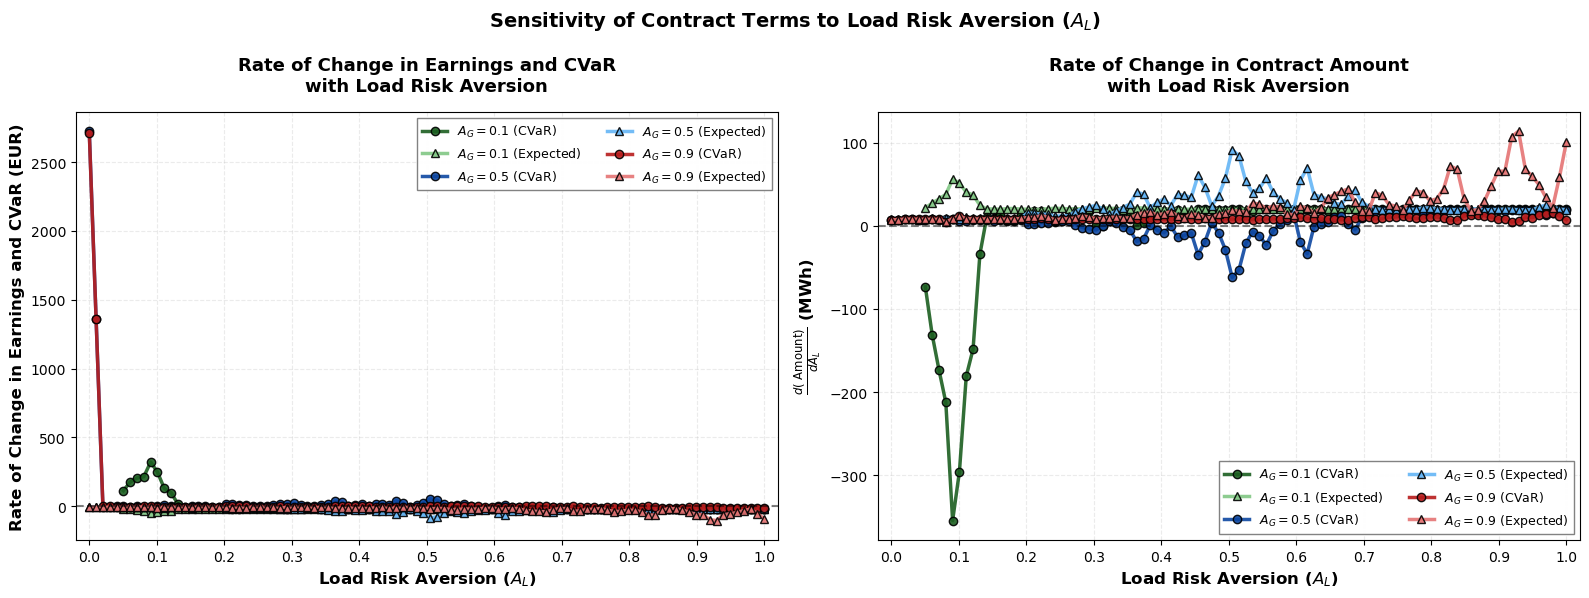

In [31]:
plt.clf()
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for different A_G values
colors_cvar = {'0.1': '#1B5E20', '0.5': '#0D47A1', '0.9': '#B71C1C'}  # Darker shades for CVaR
colors_earn = {'0.1': '#81C784', '0.5': '#64B5F6', '0.9': '#E57373'}  # Lighter shades for Earnings

for idx, AG_fixed in enumerate(A_G_fixed_samples):
    df_risk_plot_AL = dict_A_G_fixed[AG_fixed].copy()
    df_feasible = df_risk_plot_AL[df_risk_plot_AL['Feasible']].copy().sort_values('A_L')
    
    if len(df_feasible) > 1:
        color_cvar = colors_cvar[str(AG_fixed)]
        color_earn = colors_earn[str(AG_fixed)]
        
        # Calculate derivatives (finite differences)
        df_feasible['dCVaR_L_dAL'] = np.gradient(df_feasible['CVaR_L'].values, 
                                                  df_feasible['A_L'].values)
        df_feasible['dEarnings_L_dAL'] = np.gradient(df_feasible['Earnings_L'].values, 
                                                      df_feasible['A_L'].values)
        df_feasible['dCVaR_G_dAL'] = np.gradient(df_feasible['CVaR_G'].values, 
                                                  df_feasible['A_L'].values)
        df_feasible['dEarnings_G_dAL'] = np.gradient(df_feasible['Earnings_G'].values, 
                                                      df_feasible['A_L'].values)
        
        # Left plot: Rate of change in Strike Price
        ax1.plot(df_feasible['A_L'], df_feasible['dCVaR_L_dAL'],
                 color=color_cvar, linewidth=2.5, alpha=0.9,
                 label=f'$A_G = {AG_fixed}$ (CVaR)', marker='o', markersize=6,
                 markeredgecolor='black', markeredgewidth=1)
        
        ax1.plot(df_feasible['A_L'], df_feasible['dEarnings_L_dAL'],
                 color=color_earn, linewidth=2.5, alpha=0.9,
                 label=f'$A_G = {AG_fixed}$ (Expected)', marker='^', markersize=6,
                 markeredgecolor='black', markeredgewidth=1)
        
        # Right plot: Rate of change in Contract Amount
        ax2.plot(df_feasible['A_L'], df_feasible['dCVaR_G_dAL'],
                 color=color_cvar, linewidth=2.5, alpha=0.9,
                 label=f'$A_G = {AG_fixed}$ (CVaR)', marker='o', markersize=6,
                 markeredgecolor='black', markeredgewidth=1)
        
        ax2.plot(df_feasible['A_L'], df_feasible['dEarnings_G_dAL'],
                 color=color_earn, linewidth=2.5, alpha=0.9,
                 label=f'$A_G = {AG_fixed}$ (Expected)', marker='^', markersize=6,
                 markeredgecolor='black', markeredgewidth=1)

# Add horizontal line at zero for reference
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Left plot formatting
ax1.set_xlabel('Load Risk Aversion ($A_L$)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Rate of Change in Earnings and CVaR (EUR)', fontsize=12, fontweight='bold')
ax1.set_title('Rate of Change in Earnings and CVaR\nwith Load Risk Aversion',
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=9, framealpha=0.98, loc='best', ncol=2, 
           edgecolor='gray', fancybox=False)
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax1.set_xlim(-0.02, 1.02)
ax1.set_xticks(np.arange(0, 1.1, 0.1))

# Right plot formatting
ax2.set_xlabel('Load Risk Aversion ($A_L$)', fontsize=12, fontweight='bold')
ax2.set_ylabel('$\\frac{d(\mathrm{\\ Amount})}{dA_L}$ (MWh)', fontsize=12, fontweight='bold')
ax2.set_title('Rate of Change in Contract Amount\nwith Load Risk Aversion',
              fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=9, framealpha=0.98, loc='best', ncol=2,
           edgecolor='gray', fancybox=False)
ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax2.set_xlim(-0.02, 1.02)
ax2.set_xticks(np.arange(0, 1.1, 0.1))

# Overall title
plt.suptitle(
    'Sensitivity of Contract Terms to Load Risk Aversion ($A_L$)',
    fontsize=14, fontweight='bold', y=0.99
)

plt.tight_layout()
plt.show()